In [1]:
!python --version

Python 3.7.5


In [2]:
pip install pyarrow

     |████████████████████████████████| 25.5 MB 22.1 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
!cat requirements.txt

notebook==6.4.5
pandas==0.25.3
numpy==1.17.4
matplotlib==3.1.1
seaborn==0.9.0
scipy==1.3.2
scikit-learn==0.24.2
statsmodels==0.10.1
google-cloud-storage==1.40.0
google-cloud-bigquery==2.20.0
google-cloud-bigquery-storage==2.6.0
ipykernel


### Table of Contents
[Objective](#obj)<br>
[Data Discovery](#eda)<br>
[Feature Selection](#sel)<br>
[Modeling](#model)<br>


## Upload Data From BQ

In [3]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.QUANT_STG.TTS_90Days`
    """
data = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data.head()

,customer_id,address_id,time_interval,PREVIOUS_BUY_DATE,Fiscal_month,sales_6M,coupon_expense_6M,Frequency_6M,Recency_6M,BUYS_Q_03,...,BBB_ONCOUPON_M_DECILE,pct_txns_on_mkd_disc,NUM_PERIODS,NUM_PRODUCT_GROUPS,HOME_STORE_DISTANCE_NBR,BBB_MOST_SHOP_STR_DIST,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT,Target
0,1000040308201,3.000036e+12,53.0,16OCT2019,2019P07,49.44,13.50,3,14.0,3,...,1.000000000,0.083300000,6.0,2.0,5.41000000000000000000000000000000000000,6.33798615840000000000000000000000000000,99,99,99,1
1,1000090527041,3.000071e+12,71.0,25SEP2019,2019P06,531.92,106.40,4,77.0,1,...,1.000000000,0.090900000,6.0,1.0,2.86000000000000000000000000000000000000,2.85830748320000000000000000000000000000,1,2,1,1
2,1000179236205,3.000114e+12,9.0,20NOV2019,2019P08,371.04,77.80,6,17.0,1,...,1.000000000,0E-9,6.0,4.0,4.41000000000000000000000000000000000000,8.20209973440000000000000000000000000000,1,99,1,1
3,1000285494627,3.000128e+12,56.0,22MAY2019,2019P02,1022.12,155.50,4,27.0,1,...,1.000000000,0E-9,6.0,1.0,1.68000000000000000000000000000000000000,3.47967867520000000000000000000000000000,1,99,2,1
4,1000449823911,3.000159e+12,85.0,14SEP2019,2019P06,715.61,136.73,6,58.0,5,...,1.000000000,0.181800000,6.0,1.0,2.86000000000000000000000000000000000000,2.17479917200000000000000000000000000000,99,99,99,1


### Import Libraries

In [4]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import skew, iqr
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif,VarianceThreshold,SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, auc, confusion_matrix, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%config Application.log_level = "ERROR"

## EDA / Imputation

In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 33 columns):
customer_id                 int64
address_id                  float64
time_interval               float64
PREVIOUS_BUY_DATE           object
Fiscal_month                object
sales_6M                    float64
coupon_expense_6M           float64
Frequency_6M                int64
Recency_6M                  float64
BUYS_Q_03                   object
COUPON_Q_03                 object
PH_PFREQ90D                 object
PH_CFREQ90D                 object
PH_REDEEM90D                object
PH_MREDEEM90D               object
PH_MCPSALE90D               object
PH_MREDEEM730D_PERC         object
BBB_INSTORE_RFM_DECILE      object
BBB_ECOM_R_DECILE           object
BBB_OFFCOUPON_RFM_DECILE    object
BBB_RFM_DECILE              object
BBB_RFM_DECILE_2Y           object
BBB_ECOM_M_DECILE           object
BBB_ONCOUPON_M_DECILE       object
pct_txns_on_mkd_disc        object
NUM_PERIO

In [5]:
#Imputation
for col in data.columns:
    if 'DECILE' in col:
        data[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data[col].fillna(366, inplace=True)
    elif 'Recency_6M' in col:
        data[col].fillna(366, inplace=True)
    else:
        data[col].fillna(0, inplace=True)

data.isnull().sum()

customer_id                 0
address_id                  0
time_interval               0
PREVIOUS_BUY_DATE           0
Fiscal_month                0
sales_6M                    0
coupon_expense_6M           0
Frequency_6M                0
Recency_6M                  0
BUYS_Q_03                   0
COUPON_Q_03                 0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
PH_REDEEM90D                0
PH_MREDEEM90D               0
PH_MCPSALE90D               0
PH_MREDEEM730D_PERC         0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
BBB_RFM_DECILE              0
BBB_RFM_DECILE_2Y           0
BBB_ECOM_M_DECILE           0
BBB_ONCOUPON_M_DECILE       0
pct_txns_on_mkd_disc        0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
HOME_STORE_DISTANCE_NBR     0
BBB_MOST_SHOP_STR_DIST      0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
Target                      0
dtype: int

In [6]:
key = ['customer_id','address_id'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data[key] = data[key].astype("object")
key1 = ['BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','pct_txns_on_mkd_disc','HOME_STORE_DISTANCE_NBR','BBB_MOST_SHOP_STR_DIST']
data[key1]=data[key1].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 33 columns):
customer_id                 object
address_id                  object
time_interval               float64
PREVIOUS_BUY_DATE           object
Fiscal_month                object
sales_6M                    float64
coupon_expense_6M           float64
Frequency_6M                int64
Recency_6M                  float64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
PH_REDEEM90D                object
PH_MREDEEM90D               int64
PH_MCPSALE90D               object
PH_MREDEEM730D_PERC         object
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
BBB_RFM_DECILE              object
BBB_RFM_DECILE_2Y           object
BBB_ECOM_M_DECILE           object
BBB_ONCOUPON_M_DECILE       object
pct_txns_on_mkd_disc        int64
NUM_PERIODS       

In [7]:
data.describe()

,time_interval,sales_6M,coupon_expense_6M,Frequency_6M,Recency_6M,BUYS_Q_03,COUPON_Q_03,PH_PFREQ90D,PH_CFREQ90D,PH_MREDEEM90D,...,BBB_OFFCOUPON_RFM_DECILE,pct_txns_on_mkd_disc,NUM_PERIODS,NUM_PRODUCT_GROUPS,HOME_STORE_DISTANCE_NBR,BBB_MOST_SHOP_STR_DIST,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT,Target
count,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,...,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000
mean,44.234,230.746,37.792,2.896,188.077,0.979,0.781,1.697,1.784,0.433,...,8.519,0.042,2.981,3.419,4.595,311.097,38.380,48.579,28.356,0.558
std,62.183,334.412,61.180,2.431,159.440,18.954,10.157,1.779,1.561,1.013,...,3.539,0.201,2.774,6.294,14.754,1217.572,47.401,48.608,43.706,0.497
min,0.000,-1237.960,-885.800,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000
25%,0.000,50.740,3.400,1.000,31.000,0.000,0.000,0.000,0.000,0.000,...,6.000,0.000,1.000,1.000,1.000,0.000,1.000,2.000,1.000,0.000
50%,18.000,129.400,18.600,2.000,119.000,0.000,0.000,1.000,2.000,0.000,...,11.000,0.000,2.000,1.000,3.000,3.000,2.000,3.000,2.000,1.000
75%,62.000,288.370,50.000,4.000,366.000,1.000,1.000,3.000,3.000,0.000,...,11.000,0.000,5.000,3.000,5.000,8.000,99.000,99.000,99.000,1.000
max,364.000,65609.930,17514.800,20.000,366.000,5260.000,2928.000,15.000,17.000,14.000,...,11.000,1.000,12.000,529.000,3809.000,10352.000,99.000,99.000,99.000,1.000


In [572]:
data.sales_6M.loc[data.sales_6M<0]=0
data.coupon_expense_6M.loc[data.coupon_expense_6M<0]=0


<a id='eda'></a>

In [262]:
data.isnull().sum()

customer_id                 0
address_id                  0
time_interval               0
PREVIOUS_BUY_DATE           0
Fiscal_month                0
sales_6M                    0
coupon_expense_6M           0
Frequency_6M                0
Recency_6M                  0
BUYS_Q_03                   0
COUPON_Q_03                 0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
PH_REDEEM90D                0
PH_MREDEEM90D               0
PH_MCPSALE90D               0
PH_MREDEEM730D_PERC         0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
BBB_RFM_DECILE              0
BBB_RFM_DECILE_2Y           0
BBB_ECOM_M_DECILE           0
BBB_ONCOUPON_M_DECILE       0
pct_txns_on_mkd_disc        0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
HOME_STORE_DISTANCE_NBR     0
BBB_MOST_SHOP_STR_DIST      0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
Target                      0
dtype: int

In [263]:
data['Target'].describe()

count   5000000.000
mean          0.558
std           0.497
min           0.000
25%           0.000
50%           1.000
75%           1.000
max           1.000
Name: Target, dtype: float64

In [8]:
counter=0
for col in data.columns:
    if int(round(1 - (data[col].isnull().sum() / len(data)), 2) * 100) != 100:
        print(col, 'has', int(round(1 - (data[col].isnull().sum() / len(data)), 2) * 100),'per cent coverage.')
        counter+=1
    else:
         continue
        
if counter == 0:
    print('All features are at 100% coverage.')


All features are at 100% coverage.


In [ ]:
# Categorical vs Continuous
cols = ['Column_name', 'Length','type']
lst = []
for col in data.columns:
    
    if int(len(data[col].unique()))>=12 and data[col].dtype!='O':
        lst.append([str(col),int(len(data[col].unique())),'Continuous'])
    elif int(len(data[col].unique()))<12 and data[col].dtype!='O' and 'DECILE' not in col:
        lst.append([str(col),int(len(data[col].unique())),'Categorical'])
    else:
        lst.append([str(col),int(len(data[col].unique())),'Other'])
Col_type = pd.DataFrame(lst, columns=cols)



In [ ]:
Cat=Col_type.loc[Col_type['type'] =='Categorical'].Column_name.tolist()
Con=Col_type.loc[Col_type['type'] =='Continuous'].Column_name.tolist()

In [ ]:
chY = SelectKBest(chi2, k=5)
X_new = chY.fit_transform(data[Cat], data['Target'])
column_names1 = [column[0]  for column in zip(data[Cat].columns,chY.get_support()) if column[1]]

In [ ]:
column_names1

In [ ]:
#F-test 
sel_f = SelectKBest(f_classif, k=6)
X_new = sel_f.fit_transform(data[Con], data['Target'])
column_names2 = [column[0]  for column in zip(data[Con].columns,sel_f.get_support()) if column[1]]

In [ ]:
column_names2

In [ ]:
data.isnull().sum()

In [265]:
var_list = [
    'sales_6M','coupon_expense_6M','Frequency_6M',
    'Recency_6M','BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE',
    'BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','pct_txns_on_mkd_disc','NUM_PERIODS','NUM_PRODUCT_GROUPS',
    'PRESENCE_OF_CHILD','EDU_1ST','MARITAL_STAT'
]

In [266]:
corr = data.corr()
print(abs(corr['Target'][:-1]).sort_values(ascending=False))
# sb.pairplot(data.sample(21987))
# plt.show()
#abs(corr['TARGET'][:-1]).sort_values(ascending=False).to_csv('Corr.csv')

Recency_6M                 0.542
Frequency_6M               0.424
NUM_PERIODS                0.328
BBB_INSTORE_RFM_DECILE     0.325
coupon_expense_6M          0.261
time_interval              0.254
sales_6M                   0.252
BBB_OFFCOUPON_RFM_DECILE   0.174
PH_MREDEEM90D              0.168
PH_PFREQ90D                0.159
PH_CFREQ90D                0.145
BBB_ECOM_R_DECILE          0.144
NUM_PRODUCT_GROUPS         0.074
pct_txns_on_mkd_disc       0.061
MARITAL_STAT               0.038
PRESENCE_OF_CHILD          0.033
EDU_1ST                    0.032
COUPON_Q_03                0.031
HOME_STORE_DISTANCE_NBR    0.028
BUYS_Q_03                  0.019
BBB_MOST_SHOP_STR_DIST     0.003
Name: Target, dtype: float64


In [267]:
feat_list=[]
feat_labels = [column for column in data[var_list].columns]
#RF variable elimination
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=30, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(data[var_list], data['Target'])

# Print the name and gini importance of each feature
for feature in zip(feat_labels, clf.feature_importances_):
    feat_list.append(feature)
features_rf = pd.DataFrame(feat_list).sort_values(by=1, ascending=False)

In [268]:
features_rf

,0,1
0,sales_6M,0.206
3,Recency_6M,0.198
1,coupon_expense_6M,0.135
2,Frequency_6M,0.105
14,NUM_PRODUCT_GROUPS,0.046
13,NUM_PERIODS,0.042
9,BBB_INSTORE_RFM_DECILE,0.038
11,BBB_OFFCOUPON_RFM_DECILE,0.034
7,PH_PFREQ90D,0.029
16,EDU_1ST,0.027


In [13]:
target = "Target"

features = [
    col for col in data.columns 
    if (col not in ['customer_id', 'address_id', 'PREVIOUS_BUY_DATE','Fiscal_month', target,'Time_interval'])
]

features

['time_interval',
 'sales_6M',
 'coupon_expense_6M',
 'Frequency_6M',
 'Recency_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'PH_REDEEM90D',
 'PH_MREDEEM90D',
 'PH_MCPSALE90D',
 'PH_MREDEEM730D_PERC',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'BBB_RFM_DECILE',
 'BBB_RFM_DECILE_2Y',
 'BBB_ECOM_M_DECILE',
 'BBB_ONCOUPON_M_DECILE',
 'pct_txns_on_mkd_disc',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'HOME_STORE_DISTANCE_NBR',
 'BBB_MOST_SHOP_STR_DIST',
 'PRESENCE_OF_CHILD',
 'EDU_1ST',
 'MARITAL_STAT']

In [270]:
feat_1 = features[:5]
feat_2 = features[5:10]
feat_3 = features[10:15]
feat_4 = features[15:20]


feat_lst = [
    feat_1, feat_2, feat_3,feat_4
]

Frequency_6M        0.424
coupon_expense_6M   0.261
sales_6M            0.252
BUYS_Q_03           0.019
Recency_6M          0.005
Name: Target, dtype: float64


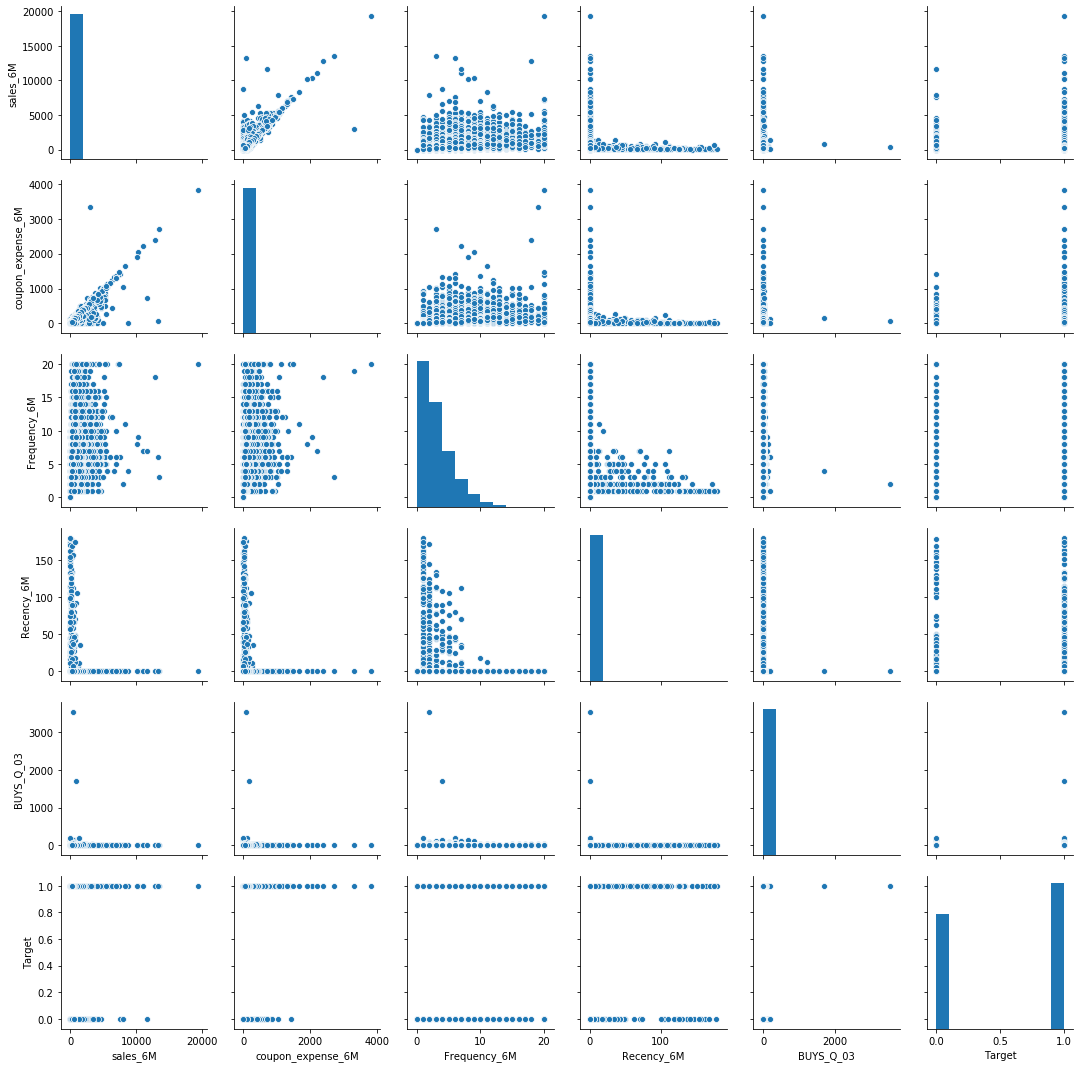

PH_MREDEEM90D             0.168
PH_PFREQ90D               0.160
PH_CFREQ90D               0.146
COUPON_Q_03               0.031
BBB_INSTORE_RFM_DECILE   -0.325
Name: Target, dtype: float64


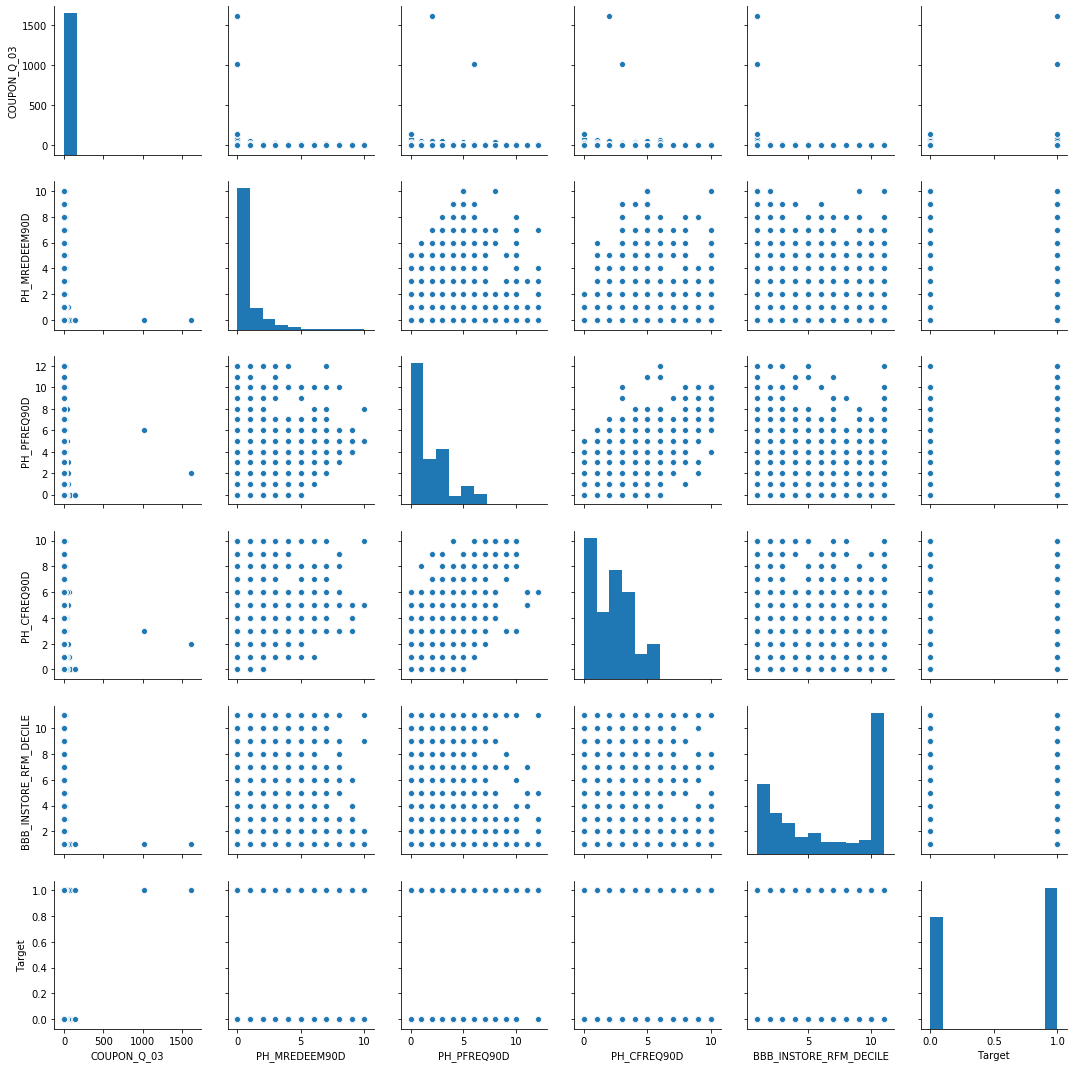

NUM_PERIODS                 0.328
NUM_PRODUCT_GROUPS          0.074
pct_txns_on_mkd_disc       -0.061
BBB_ECOM_R_DECILE          -0.144
BBB_OFFCOUPON_RFM_DECILE   -0.174
Name: Target, dtype: float64


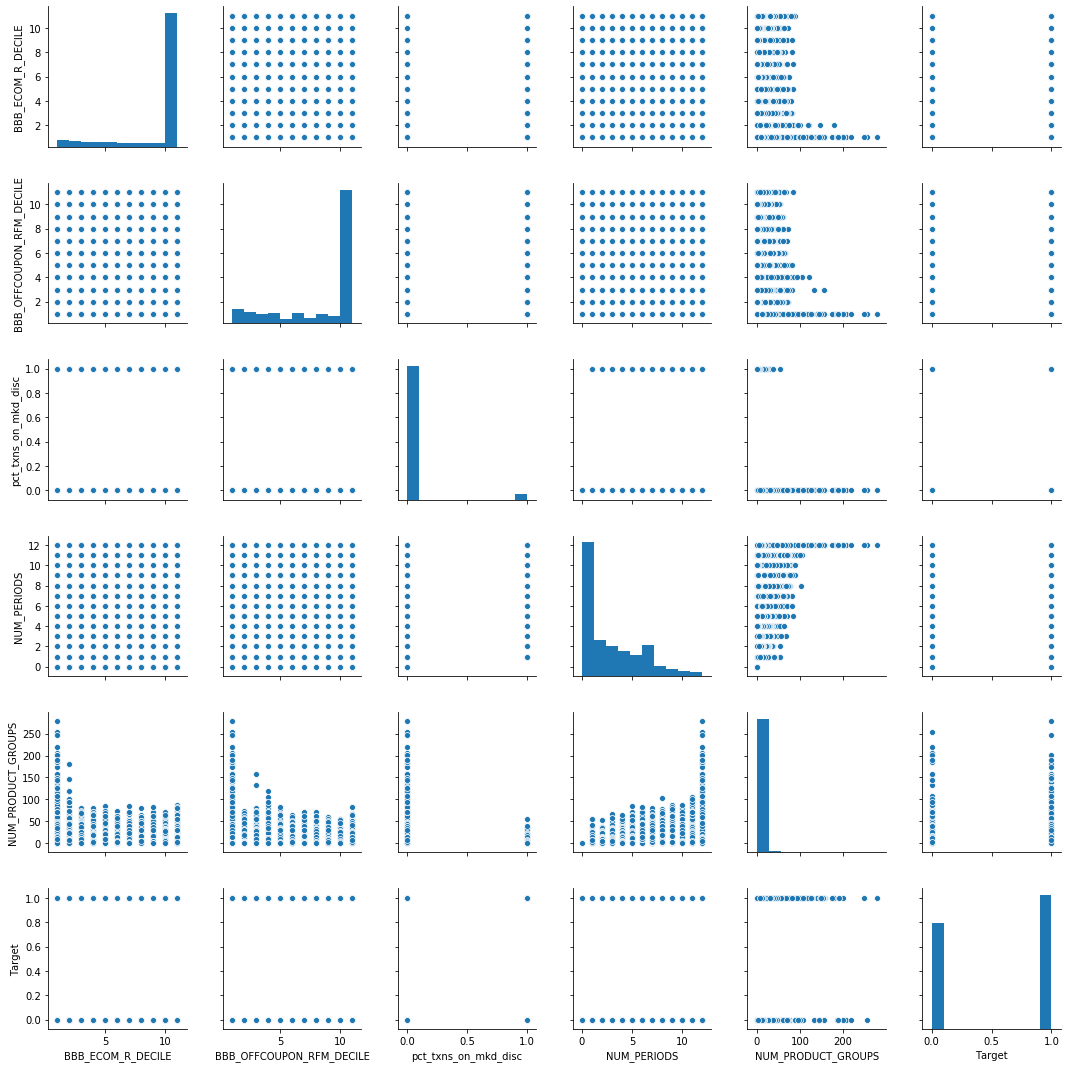

EDU_1ST             -0.032
PRESENCE_OF_CHILD   -0.033
MARITAL_STAT        -0.038
Time_interval       -0.254
Name: Target, dtype: float64


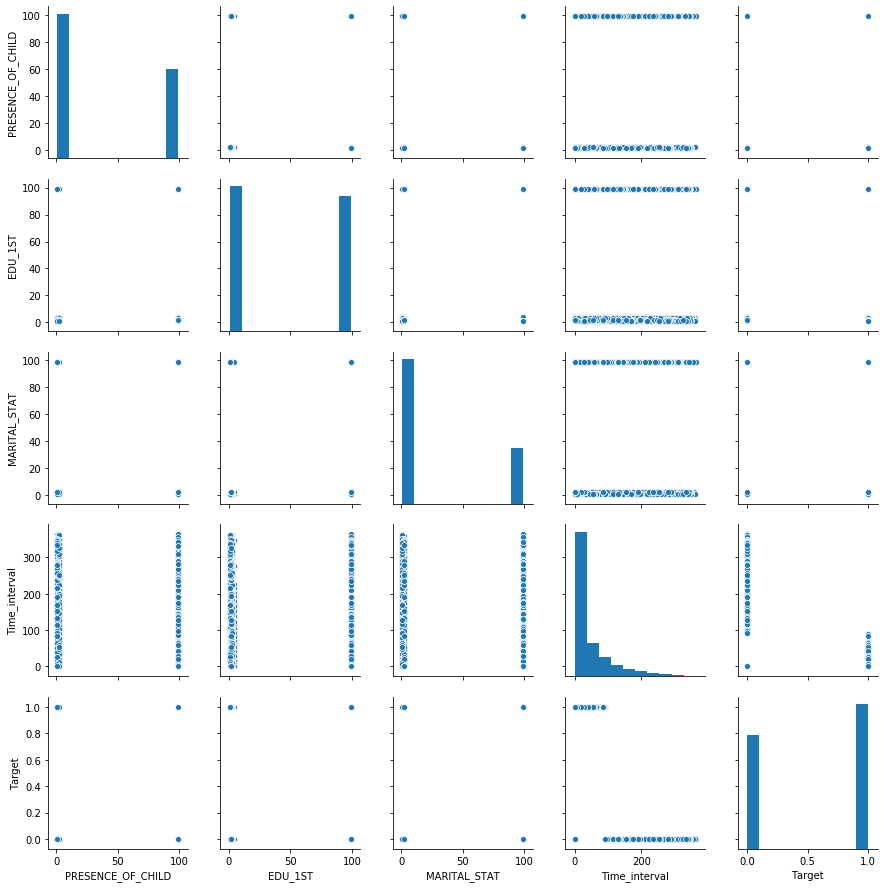

In [166]:
for feat in feat_lst:
    lst = [f for f in feat]
    if target not in lst:
        lst.append(target)
    corr = data[lst].corr()
    print(corr[target][:-1].sort_values(ascending=False))

    sb.pairplot(data[lst].sample(200000, random_state=7))
    plt.show()

In [ ]:
for feat in feat_lst:
    data[feat].sample(20000, random_state=7).hist(figsize=(10,8), bins=50)
    plt.show()

In [ ]:
target = 'Target'


features = [
    col for col in data.columns
    if col not in [key, target] 
]

data[features].hist(figsize=(25, 16), bins=50)
plt.show()

<a id='sel'></a>

### Feature Selection

In [20]:
to_test = data[[
    'sales_6M','coupon_expense_6M','Frequency_6M',
    'Recency_6M','BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE',
    'BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','pct_txns_on_mkd_disc','NUM_PERIODS','NUM_PRODUCT_GROUPS',
    'PRESENCE_OF_CHILD','EDU_1ST','MARITAL_STAT','Target'
]]

In [ ]:
# from sklearn.linear_model import LinearRegression
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
# model = LinearRegression()
# #Initializing RFE model
# rfe = RFE(model, 30)
# #Transforming data using RFE
# X_rfe = rfe.fit_transform(data1[useful_vars],data1['FLAG_90'])  
# #Fitting the data to model
# model.fit(X_rfe,data1['FLAG_90'])
# print(rfe.support_)
# print(rfe.ranking_)

In [ ]:
# def backward_elimination(data2, target,significance_level = 0.1):
#     features = data2.columns.tolist()
#     while(len(features)>0):
#         features_with_constant = sm.add_constant(data2[features])
#         p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
#         max_p_value = p_values.max()
#         if(max_p_value >= significance_level):
#             excluded_feature = p_values.idxmax()
#             features.remove(excluded_feature)
#         else:
#             break 
#     return features

In [ ]:
# sbs = SFS(LinearRegression(),
#          k_features=20,
#          forward=False,
#          floating=False,
#          cv=5)
# sbs.fit(data2, target)
# sbs.k_feature_names_

In [ ]:
# # Create a selector object that will use the random forest classifier to identify
# # features that have an importance of more than 0.15
# sfm = SelectFromModel(clf, threshold=0.15)

# # Train the selector
# sfm.fit(data1[useful_vars],data1['FLAG_90'])

In [271]:
f_list = []

for f in features:
    f_list.append(f)
    
f_list.append(target)
f_list

['time_interval',
 'sales_6M',
 'coupon_expense_6M',
 'Frequency_6M',
 'Recency_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'PH_REDEEM90D',
 'PH_MREDEEM90D',
 'PH_MCPSALE90D',
 'PH_MREDEEM730D_PERC',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'BBB_RFM_DECILE',
 'BBB_RFM_DECILE_2Y',
 'BBB_ECOM_M_DECILE',
 'BBB_ONCOUPON_M_DECILE',
 'pct_txns_on_mkd_disc',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'HOME_STORE_DISTANCE_NBR',
 'BBB_MOST_SHOP_STR_DIST',
 'PRESENCE_OF_CHILD',
 'EDU_1ST',
 'MARITAL_STAT',
 'Target']

In [139]:
log_data = data[features].sample(500000, random_state=42)
vif = pd.DataFrame()

vif["variables"] = log_data.columns
vif["VIF"] = [
    variance_inflation_factor(log_data.values, i)
    for i in range(log_data.shape[1])
]
vif.sort_values(by='VIF', ascending=False)

,variables,VIF
5,COUPON_Q_03,145.164
4,BUYS_Q_03,144.222
11,BBB_OFFCOUPON_RFM_DECILE,11.469
0,sales_6M,9.697
10,BBB_ECOM_R_DECILE,9.479
1,coupon_expense_6M,9.131
9,BBB_INSTORE_RFM_DECILE,8.012
8,PH_CFREQ90D,6.180
7,PH_PFREQ90D,5.138
13,NUM_PERIODS,5.078


In [157]:
for f in features:
    if f in ['BUYS_Q_03','BBB_ECOM_R_DECILE','coupon_expense_6M','PH_CFREQ90D','BBB_OFFCOUPON_RFM_DECILE','PH_PFREQ90D','NUM_PERIODS','EDU_1ST','PRESENCE_OF_CHILD','sales_6M']:
        features.remove(f)
  
# for some reason, badges_5382_low_value_cart_abandoner_bbby doesn't get deleted...
#features.remove('badges_5382_low_value_cart_abandoner_bbby')
log_data = log_data[features]
vif = pd.DataFrame()

vif["variables"] = log_data.columns
vif["VIF"] = [
    variance_inflation_factor(log_data.values, i)
    for i in range(log_data.shape[1])
]
vif.sort_values(by='VIF', ascending=False)

,variables,VIF
3,BBB_INSTORE_RFM_DECILE,1.836
0,Frequency_6M,1.682
6,MARITAL_STAT,1.605
5,NUM_PRODUCT_GROUPS,1.368
4,pct_txns_on_mkd_disc,1.061
2,COUPON_Q_03,1.016
1,Recency_6M,1.001


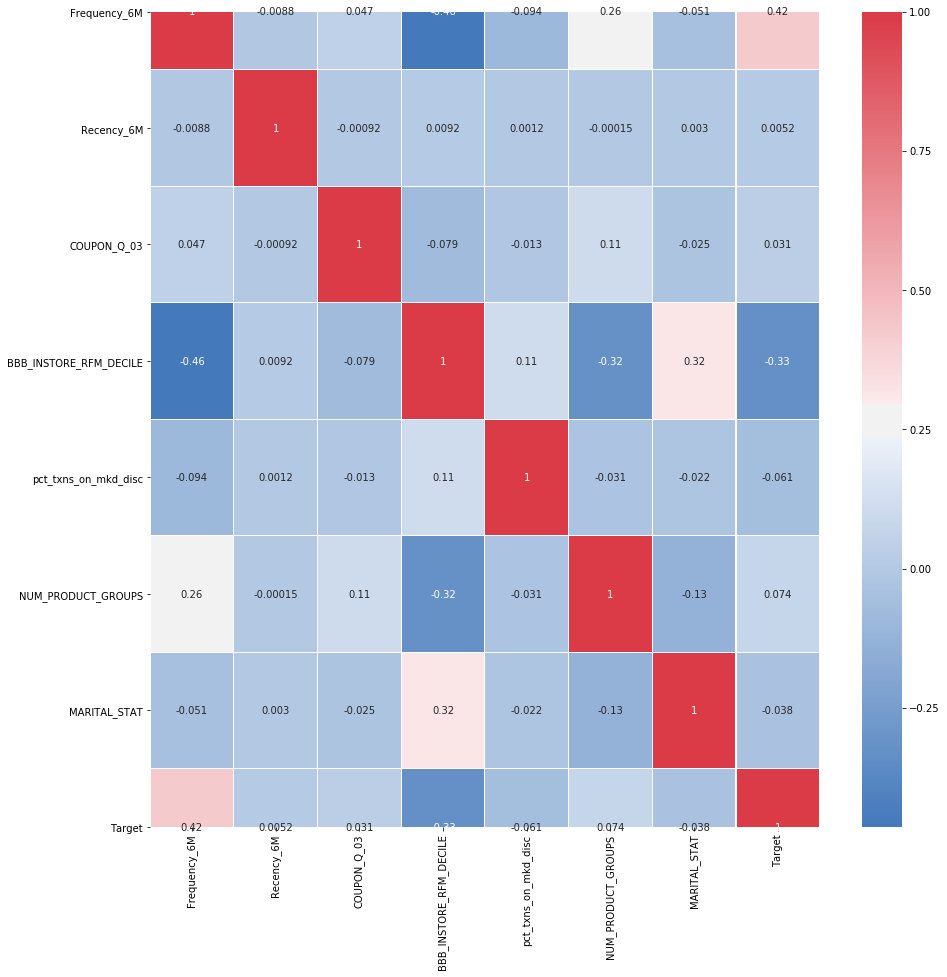

In [189]:
for f in features:
    if f in ['BUYS_Q_03','BBB_ECOM_R_DECILE','coupon_expense_6M','PH_CFREQ90D','BBB_OFFCOUPON_RFM_DECILE','PH_PFREQ90D','NUM_PERIODS','EDU_1ST','PRESENCE_OF_CHILD','sales_6M']:
        features.remove(f)
        
f_list = []

for f in features:
    f_list.append(f)
    
f_list.append(target)
corr = data[f_list].corr()

cmap = sb.diverging_palette(250, 10, as_cmap=True)
fig = plt.figure(figsize=(15, 15))

sb.heatmap(corr,
           cmap=cmap,
           annot=True,
           xticklabels=corr.columns,
           yticklabels=corr.columns,
           linewidths=.25)

plt.show()

In [163]:
from collections import OrderedDict

dic = {}
samp = data

for feat in features:
    logit = LogisticRegression(solver='lbfgs')
    logit.fit(data[feat].values.reshape(-1, 1), data[target])
    dic[feat] = roc_auc_score(
        data[target],
        logit.predict_proba(data[feat].values.reshape(-1, 1))[:, 1])

c_stat = OrderedDict(sorted(dic.items(), key=lambda x: x[1], reverse=True))
c_stat

OrderedDict([('Frequency_6M', 0.7798443284750871),
             ('BBB_INSTORE_RFM_DECILE', 0.6847594625830198),
             ('COUPON_Q_03', 0.6199233006837054),
             ('NUM_PRODUCT_GROUPS', 0.5644009972553534),
             ('MARITAL_STAT', 0.5252740434772167),
             ('pct_txns_on_mkd_disc', 0.5122410638667916),
             ('Recency_6M', 0.50034447184631)])

In [168]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = RobustScaler()

l = pd.DataFrame()
l[features] =  pd.DataFrame(scaler.fit_transform(data[features]),columns=features)
z = data[target]

l_train, l_test, z_train, z_test = train_test_split(l,
                                                    z,
                                                    test_size=0.2,
                                                    random_state=42)
l.head()

,Frequency_6M,Recency_6M,COUPON_Q_03,BBB_INSTORE_RFM_DECILE,pct_txns_on_mkd_disc,NUM_PRODUCT_GROUPS,MARITAL_STAT
0,0.000,0.000,0.000,0.556,0.000,-0.500,-0.010
1,-0.333,0.000,0.000,0.556,0.000,-0.500,0.990
2,0.000,0.000,0.000,0.556,0.000,-0.500,0.000
3,-0.667,0.000,0.000,0.556,0.000,-0.500,0.990
4,-0.333,0.000,0.000,0.556,0.000,-0.500,0.990


In [169]:
import statsmodels.api as sm

X = sm.add_constant(l_train)
y = z_train.copy()

model = sm.OLS(y, X, missing='raise')
result = model.fit()

print(result.summary())

/opt/conda/envs/timetoshop/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                 1.497e+05
Date:                Thu, 16 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:50:44   Log-Likelihood:            -2.4104e+06
No. Observations:             4000000   AIC:                         4.821e+06
Df Residuals:                 3999992   BIC:                         4.821e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [108]:
param_dist = {
    'n_estimators': list(range(100, 150, 20)),
    'max_depth': list(range(5, 20, 5)),
    'min_samples_split': list(range(2, 21, 4)),
    'min_samples_leaf': list(range(2, 11, 2)),
    'max_features': [0.5, 0.1, 'auto'],
    'min_impurity_decrease': [0.1, 0.00001]
}

y = data[target]

d_train, d_test, y_train, y_test = train_test_split(data[var_list],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=7)

In [23]:
weights = np.linspace(0.05, 0.95, 10)

param_dist = {
    'C': [0.01, 1],
    'class_weight': [{
        0: x,
        1: 1.0 - x
    } for x in weights]
}


In [172]:
search = RandomizedSearchCV(LogisticRegression(solver='saga',
                                               penalty='l2',
                                               max_iter=5000,
                                               warm_start=True),
                            param_distributions=param_dist,
                            scoring='neg_log_loss',
                            random_state=42,
                            cv=5,
                            n_iter=3,
                            refit='neg_log_loss',
                            n_jobs=20,
                            verbose=2)

search.fit(l_train, z_train)
search.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   8 out of  15 | elapsed: 10.7min remaining:  9.4min


[CV] class_weight={0: 0.5499999999999999, 1: 0.45000000000000007}, C=1 
[CV]  class_weight={0: 0.5499999999999999, 1: 0.45000000000000007}, C=1, total= 8.4min
[CV] class_weight={0: 0.5499999999999999, 1: 0.45000000000000007}, C=1 
[CV]  class_weight={0: 0.5499999999999999, 1: 0.45000000000000007}, C=1, total= 8.4min
[CV] class_weight={0: 0.5499999999999999, 1: 0.45000000000000007}, C=1 
[CV]  class_weight={0: 0.5499999999999999, 1: 0.45000000000000007}, C=1, total= 8.5min
[CV] class_weight={0: 0.5499999999999999, 1: 0.45000000000000007}, C=1 
[CV]  class_weight={0: 0.5499999999999999, 1: 0.45000000000000007}, C=1, total= 8.5min
[CV] class_weight={0: 0.5499999999999999, 1: 0.45000000000000007}, C=1 
[CV]  class_weight={0: 0.5499999999999999, 1: 0.45000000000000007}, C=1, total= 8.5min
[CV] class_weight={0: 0.75, 1: 0.25}, C=1 ............................
[CV] ............. class_weight={0: 0.75, 1: 0.25}, C=1, total=10.6min
[CV] class_weight={0: 0.75, 1: 0.25}, C=1 .....................

[Parallel(n_jobs=20)]: Done  15 out of  15 | elapsed: 27.2min finished


[CV] class_weight={0: 0.05, 1: 0.95}, C=0.01 .........................
[CV] .......... class_weight={0: 0.05, 1: 0.95}, C=0.01, total=26.7min
[CV] class_weight={0: 0.05, 1: 0.95}, C=0.01 .........................
[CV] .......... class_weight={0: 0.05, 1: 0.95}, C=0.01, total=26.8min
[CV] class_weight={0: 0.05, 1: 0.95}, C=0.01 .........................
[CV] .......... class_weight={0: 0.05, 1: 0.95}, C=0.01, total=26.8min
[CV] class_weight={0: 0.05, 1: 0.95}, C=0.01 .........................
[CV] .......... class_weight={0: 0.05, 1: 0.95}, C=0.01, total=27.0min
[CV] class_weight={0: 0.05, 1: 0.95}, C=0.01 .........................
[CV] .......... class_weight={0: 0.05, 1: 0.95}, C=0.01, total=27.2min


LogisticRegression(C=1,
                   class_weight={0: 0.5499999999999999, 1: 0.45000000000000007},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=5000, multi_class='warn',
                   n_jobs=None, penalty='l2', random_state=None, solver='saga',
                   tol=0.0001, verbose=0, warm_start=True)

In [83]:
LR =LogisticRegression(solver='saga',  penalty='l2')

LR.fit(l_train, z_train)


/opt/conda/envs/timetoshop/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [249]:
print(classification_report(z_train, search.best_estimator_.predict(l_train)))
print('---------------------------------------------------\n')
print(classification_report(z_test, search.best_estimator_.predict(l_test)))

              precision    recall  f1-score   support

           0       0.65      0.80      0.72   1766474
           1       0.81      0.66      0.73   2233526

    accuracy                           0.72   4000000
   macro avg       0.73      0.73      0.72   4000000
weighted avg       0.74      0.72      0.72   4000000

---------------------------------------------------

              precision    recall  f1-score   support

           0       0.65      0.80      0.72    441199
           1       0.81      0.66      0.73    558801

    accuracy                           0.72   1000000
   macro avg       0.73      0.73      0.72   1000000
weighted avg       0.74      0.72      0.72   1000000



In [86]:
print(classification_report(z_train, LR.predict(l_train)))
print('---------------------------------------------------\n')
print(classification_report(z_test, LR.predict(l_test)))

              precision    recall  f1-score   support

           0       0.64      0.49      0.56   1834896
           1       0.67      0.79      0.73   2391680

    accuracy                           0.66   4226576
   macro avg       0.66      0.64      0.64   4226576
weighted avg       0.66      0.66      0.65   4226576

---------------------------------------------------

              precision    recall  f1-score   support

           0       0.64      0.49      0.56    459075
           1       0.67      0.79      0.72    597569

    accuracy                           0.66   1056644
   macro avg       0.66      0.64      0.64   1056644
weighted avg       0.66      0.66      0.65   1056644



## Extra Tree Classifier

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [11]:
from sklearn.metrics import classification_report, roc_auc_score, auc, confusion_matrix, roc_curve

In [14]:
param_dist = {
    'n_estimators': list(range(100, 150, 20)),
    'max_depth': list(range(5, 20, 5)),
    'min_samples_split': list(range(2, 21, 4)),
    'min_samples_leaf': list(range(2, 11, 2)),
    'max_features': [0.5, 0.1, 'auto'],
    'min_impurity_decrease': [0.1, 0.00001]
}

y = data[target]

d_train, d_test, y_train, y_test = train_test_split(data[var_list],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

NameError: name 'var_list' is not defined

In [ ]:
tree = ExtraTreesClassifier(criterion="entropy",
                            class_weight="balanced",
                            bootstrap=True,
                            oob_score=True,
                            random_state=42)
    


tree.fit(d_train, y_train)

In [274]:
tree = ExtraTreesClassifier(criterion="entropy",
                            class_weight="balanced",
                            bootstrap=True,
                            oob_score=True,
                            random_state=42)
    
tree_search = RandomizedSearchCV(tree,
                                 param_distributions=param_dist,
                                 cv=3,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='neg_log_loss',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)

tree_search.fit(d_train, y_train)
print(
    'Report on Training:\n',
    classification_report(y_train,
                          tree_search.best_estimator_.predict(d_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(y_test, tree_search.best_estimator_.predict(d_test)))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed: 10.2min finished


Report on Training:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74   1765715
           1       0.79      0.80      0.80   2234285

    accuracy                           0.77   4000000
   macro avg       0.77      0.77      0.77   4000000
weighted avg       0.77      0.77      0.77   4000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74    441958
           1       0.79      0.80      0.80    558042

    accuracy                           0.77   1000000
   macro avg       0.77      0.77      0.77   1000000
weighted avg       0.77      0.77      0.77   1000000



In [275]:
disp = confusion_matrix(tree_search.best_estimator_.predict(d_test),y_test)

print(disp)

[[324069 109483]
 [117889 448559]]


In [276]:
for imp, feature in sorted(zip(
        tree_search.best_estimator_.feature_importances_, d_test.columns),
                           reverse=True):
    print(feature, ':', round(imp, 4))

Recency_6M : 0.7095
Frequency_6M : 0.101
BBB_INSTORE_RFM_DECILE : 0.0804
NUM_PERIODS : 0.0507
PH_PFREQ90D : 0.0178
PH_CFREQ90D : 0.0129
NUM_PRODUCT_GROUPS : 0.009
BBB_OFFCOUPON_RFM_DECILE : 0.0039
sales_6M : 0.0039
BBB_ECOM_R_DECILE : 0.0028
COUPON_Q_03 : 0.0019
MARITAL_STAT : 0.0019
BUYS_Q_03 : 0.0012
coupon_expense_6M : 0.0011
PRESENCE_OF_CHILD : 0.0009
PH_MREDEEM90D : 0.0007
EDU_1ST : 0.0002
pct_txns_on_mkd_disc : 0.0001


In [277]:
drop = ["PH_MREDEEM90D",
        "EDU_1ST",
        "pct_txns_on_mkd_disc"
]

for f in var_list:
    if f in drop:
        var_list.remove(f)

var_list

['sales_6M',
 'coupon_expense_6M',
 'Frequency_6M',
 'Recency_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']

In [409]:
param_dist = {
    'n_estimators': list(range(100, 150, 20)),
    'max_depth': list(range(5, 20, 5)),
    'min_samples_split': list(range(2, 21, 4)),
    'min_samples_leaf': list(range(2, 11, 2)),
    'max_features': [0.5, 0.1, 'auto'],
    'min_impurity_decrease': [0.1, 0.00001],
    'ccp_alpha': [0.001, 0.01]
}

y = data[target]

d1_train, d1_test, y1_train, y1_test = train_test_split(data[var_list],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [279]:


tree2 = ExtraTreesClassifier(criterion="entropy",
                            class_weight="balanced",
                            bootstrap=True,
                            oob_score=True,
                            random_state=42)
    
tree_search2 = RandomizedSearchCV(tree2,
                                 param_distributions=param_dist,
                                 cv=3,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='neg_log_loss',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)


tree_search2.fit(d1_train, y1_train)

print(
    'Report on Training:\n',
    classification_report(y1_train,
                          tree_search2.best_estimator_.predict(d1_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(y1_test, tree_search2.best_estimator_.predict(d1_test)))



Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:  7.6min finished


Report on Training:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74   1765715
           1       0.79      0.80      0.80   2234285

    accuracy                           0.77   4000000
   macro avg       0.77      0.77      0.77   4000000
weighted avg       0.77      0.77      0.77   4000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74    441958
           1       0.79      0.80      0.80    558042

    accuracy                           0.77   1000000
   macro avg       0.77      0.77      0.77   1000000
weighted avg       0.77      0.77      0.77   1000000



In [15]:
var_list2=['sales_6M',
 'Frequency_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']

In [16]:
param_dist = {
    'n_estimators': list(range(100, 150, 20)),
    'max_depth': list(range(5, 20, 5)),
    'min_samples_split': list(range(2, 21, 4)),
    'min_samples_leaf': list(range(2, 11, 2)),
    'max_features': [0.5, 0.1, 'auto'],
    'min_impurity_decrease': [0.1, 0.00001]
}

y = data[target]

d2_train, d2_test, y2_train, y2_test = train_test_split(data[var_list2],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [17]:
ExtraTreesClassifier().get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:

tree3 = ExtraTreesClassifier(criterion="entropy",
                            class_weight="balanced",
                            bootstrap=True,
                            oob_score=True,
                            random_state=42)
    
tree_search3 = RandomizedSearchCV(tree3,
                                 param_distributions=param_dist,
                                 cv=3,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='neg_log_loss',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)


tree_search3.fit(d2_train, y2_train)

print(
    'Report on Training:\n',
    classification_report(y2_train,
                          tree_search3.best_estimator_.predict(d2_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(y2_test, tree_search3.best_estimator_.predict(d2_test)))



Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [406]:
print(tree_search3.best_estimator_)

ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
                     criterion='entropy', max_depth=15, max_features=0.5,
                     max_leaf_nodes=None, min_impurity_decrease=1e-05,
                     min_impurity_split=None, min_samples_leaf=10,
                     min_samples_split=14, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=True,
                     random_state=42, verbose=0, warm_start=False)


In [120]:
prob=tree_search.predict_proba(d_test)

In [121]:
prob1=prob[:,1]

In [421]:
tree_search4 = RandomizedSearchCV(tree3,
                                 param_distributions=param_dist,
                                 cv=4,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='precision',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)


tree_search4.fit(d2_train, y2_train)

print(
    'Report on Training:\n',
    classification_report(y2_train,
                          tree_search3.best_estimator_.predict(d2_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(y2_test, tree_search3.best_estimator_.predict(d2_test)))



Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed: 10.9min finished


Report on Training:
               precision    recall  f1-score   support

           0       0.70      0.73      0.72   1765715
           1       0.78      0.75      0.77   2234285

    accuracy                           0.75   4000000
   macro avg       0.74      0.74      0.74   4000000
weighted avg       0.75      0.75      0.75   4000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72    441958
           1       0.78      0.75      0.77    558042

    accuracy                           0.75   1000000
   macro avg       0.74      0.74      0.74   1000000
weighted avg       0.75      0.75      0.75   1000000



In [536]:
prob11=tree_search5.predict_proba(d2_test)
prob1=prob11[:,1]
prob0=prob11[:,0]
dfa = pd.DataFrame({'Predicted1': prob1,  'Predicted0': prob0,   'Predicted': tree_search5.best_estimator_.predict(d2_test),'Actual':y2_test})
dfa.loc[(dfa['Predicted1'] <=0.3 )].count()/1000000
dfa.loc[(dfa['Predicted1'] >=0.65 ) & (dfa['Actual'] == 0 )].count()/1000000

Predicted1   0.287
Predicted0   0.287
Predicted    0.287
Actual       0.287
dtype: float64

Predicted1   0.052
Predicted0   0.052
Predicted    0.052
Actual       0.052
dtype: float64

In [423]:
tree_search5 = RandomizedSearchCV(tree3,
                                 param_distributions=param_dist,
                                 cv=4,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='recall',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)


tree_search5.fit(d2_train, y2_train)

print(
    'Report on Training:\n',
    classification_report(y2_train,
                          tree_search5.best_estimator_.predict(d2_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(y2_test, tree_search5.best_estimator_.predict(d2_test)))


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed: 10.8min finished


Report on Training:
               precision    recall  f1-score   support

           0       0.70      0.73      0.72   1765715
           1       0.78      0.75      0.77   2234285

    accuracy                           0.75   4000000
   macro avg       0.74      0.74      0.74   4000000
weighted avg       0.75      0.75      0.75   4000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72    441958
           1       0.78      0.75      0.77    558042

    accuracy                           0.75   1000000
   macro avg       0.74      0.74      0.74   1000000
weighted avg       0.75      0.75      0.75   1000000



In [ ]:
tree_search5 = RandomizedSearchCV(tree3,
                                 param_distributions=param_dist,
                                 cv=4,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='recall',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)


tree_search5.fit(d2_train, y2_train)

print(
    'Report on Training:\n',
    classification_report(y2_train,
                          tree_search5.best_estimator_.predict(d2_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(y2_test, tree_search5.best_estimator_.predict(d2_test)))


In [122]:
prob0=prob[:,0]

In [123]:
df = pd.DataFrame({'Actual': y_test, 'Predicted1': prob1,  'Predicted0': prob0,   'Predicted': tree_search.best_estimator_.predict(d_test)})

In [124]:
df

,Actual,Predicted1,Predicted0,Predicted
3577888,0,0.559,0.441,1
4993932,1,0.870,0.130,1
4094900,1,0.852,0.148,1
4420497,0,0.209,0.791,0
634465,0,0.260,0.740,0
...,...,...,...,...
879073,0,0.487,0.513,0
461358,0,0.164,0.836,0
4559407,1,0.883,0.117,1
1450969,0,0.222,0.778,0


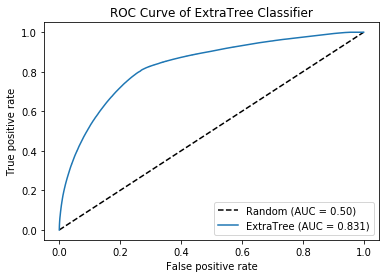

Recency_6M : 0.7095
Frequency_6M : 0.101
BBB_INSTORE_RFM_DECILE : 0.0804
NUM_PERIODS : 0.0507
PH_PFREQ90D : 0.0178
PH_CFREQ90D : 0.0129
NUM_PRODUCT_GROUPS : 0.009
BBB_OFFCOUPON_RFM_DECILE : 0.0039
sales_6M : 0.0039
BBB_ECOM_R_DECILE : 0.0028
COUPON_Q_03 : 0.0019
MARITAL_STAT : 0.0019
BUYS_Q_03 : 0.0012
coupon_expense_6M : 0.0011
PRESENCE_OF_CHILD : 0.0009
PH_MREDEEM90D : 0.0007
EDU_1ST : 0.0002
pct_txns_on_mkd_disc : 0.0001


In [280]:
fpr_, tpr_, thresholds_ = roc_curve(
    y_test,
    tree_search.best_estimator_.predict_proba(d_test)[:, 1])

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.plot(fpr_, tpr_, label='ExtraTree (AUC = %0.3f)' % (auc(fpr_, tpr_)))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve of ExtraTree Classifier')
plt.legend(loc='best')
plt.show()

for imp, feature in sorted(zip(
        tree_search.best_estimator_.feature_importances_, d_test.columns),
                           reverse=True):
    print(feature, ':', round(imp, 4))

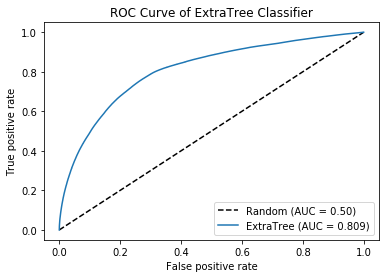

Frequency_6M : 0.5208
BBB_INSTORE_RFM_DECILE : 0.2302
NUM_PERIODS : 0.1287
PH_PFREQ90D : 0.0221
sales_6M : 0.0216
BBB_OFFCOUPON_RFM_DECILE : 0.0181
PH_CFREQ90D : 0.0164
NUM_PRODUCT_GROUPS : 0.0124
BBB_ECOM_R_DECILE : 0.0113
MARITAL_STAT : 0.0072
PH_MREDEEM90D : 0.0048
PRESENCE_OF_CHILD : 0.0031
COUPON_Q_03 : 0.0021
BUYS_Q_03 : 0.001


In [354]:
fpr_, tpr_, thresholds_ = roc_curve(
    y2_test,
    tree_search.best_estimator_.predict_proba(d2_test)[:, 1])

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.plot(fpr_, tpr_, label='ExtraTree (AUC = %0.3f)' % (auc(fpr_, tpr_)))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve of ExtraTree Classifier')
plt.legend(loc='best')
plt.show()

for imp, feature in sorted(zip(
        tree_search3.best_estimator_.feature_importances_, d2_test.columns),
                           reverse=True):
    print(feature, ':', round(imp, 4))

In [128]:
print(
    round(len(df.loc[df['Predicted1'] <= 0.3]) * 100 / len(df), 2),
    '% of customers assigned low probability')
print(
    round(
        len(df.loc[(df['Predicted1'] > 0.3)
                       & (df['Predicted1'] <= 0.5)]) * 100 / len(df),
        2), '% of customers assigned to mid probability')
print(
    round(len(df.loc[df['Predicted1'] > 0.5]) * 100 / len(df), 2),
    '% of customers assigned to high probability')

35.92 % of customers assigned low probability
8.1 % of customers assigned to mid probability
55.97 % of customers assigned to high probability


## Catboost

In [54]:
pip install catboost

     |████████████████████████████████| 67.4 MB 33.7 MB/s eta 0:00:01
     |████████████████████████████████| 23.9 MB 115.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [358]:
grid = {'max_depth': list(range(5, 20, 5)),'n_estimators':list(range(100, 150, 10))}

In [359]:
cbc = CatBoostClassifier()

In [362]:
gscv = GridSearchCV (estimator = cbc, param_grid = grid, scoring ='recall', cv = 5)

In [363]:
gscv.fit(d2_train, y2_train)

Learning rate set to 0.5
0:	learn: 0.5869118	total: 73.2ms	remaining: 7.25s
1:	learn: 0.5530923	total: 140ms	remaining: 6.85s
2:	learn: 0.5397237	total: 202ms	remaining: 6.53s
3:	learn: 0.5332239	total: 262ms	remaining: 6.29s
4:	learn: 0.5294727	total: 326ms	remaining: 6.2s
5:	learn: 0.5266830	total: 385ms	remaining: 6.03s
6:	learn: 0.5249372	total: 448ms	remaining: 5.95s
7:	learn: 0.5236115	total: 509ms	remaining: 5.85s
8:	learn: 0.5227101	total: 570ms	remaining: 5.76s
9:	learn: 0.5220705	total: 628ms	remaining: 5.66s
10:	learn: 0.5217327	total: 689ms	remaining: 5.58s
11:	learn: 0.5214097	total: 749ms	remaining: 5.49s
12:	learn: 0.5211906	total: 807ms	remaining: 5.4s
13:	learn: 0.5203758	total: 869ms	remaining: 5.34s
14:	learn: 0.5200519	total: 926ms	remaining: 5.25s
15:	learn: 0.5195224	total: 989ms	remaining: 5.19s
16:	learn: 0.5193520	total: 1.05s	remaining: 5.11s
17:	learn: 0.5190964	total: 1.11s	remaining: 5.04s
18:	learn: 0.5189694	total: 1.17s	remaining: 4.98s
19:	learn: 0.5186

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7f2c461ac490>,
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [100, 110, 120, 130, 140]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [281]:
from catboost import CatBoostClassifier # Or CatBoostRegressor
model_cb = CatBoostClassifier()
model_cb.fit(d_train, y_train)

Learning rate set to 0.355642
0:	learn: 0.5680801	total: 168ms	remaining: 2m 48s
1:	learn: 0.5289376	total: 331ms	remaining: 2m 45s
2:	learn: 0.5121958	total: 470ms	remaining: 2m 36s
3:	learn: 0.5054478	total: 618ms	remaining: 2m 33s
4:	learn: 0.5013259	total: 779ms	remaining: 2m 35s
5:	learn: 0.4982018	total: 947ms	remaining: 2m 36s
6:	learn: 0.4967718	total: 1.08s	remaining: 2m 33s
7:	learn: 0.4958793	total: 1.21s	remaining: 2m 30s
8:	learn: 0.4947419	total: 1.36s	remaining: 2m 29s
9:	learn: 0.4942503	total: 1.5s	remaining: 2m 28s
10:	learn: 0.4938747	total: 1.65s	remaining: 2m 28s
11:	learn: 0.4935835	total: 1.8s	remaining: 2m 27s
12:	learn: 0.4927629	total: 1.94s	remaining: 2m 27s
13:	learn: 0.4923455	total: 2.08s	remaining: 2m 26s
14:	learn: 0.4921211	total: 2.23s	remaining: 2m 26s
15:	learn: 0.4919322	total: 2.38s	remaining: 2m 26s
16:	learn: 0.4917172	total: 2.51s	remaining: 2m 25s
17:	learn: 0.4915576	total: 2.65s	remaining: 2m 24s
18:	learn: 0.4914267	total: 2.79s	remaining: 2

In [364]:
print(gscv.best_estimator_)

In [365]:
print(gscv.best_score_)

0.7865643818939839


In [366]:
print(gscv.best_params_)

{'max_depth': 5, 'n_estimators': 110}


In [345]:
model_cb = CatBoostClassifier()
model_cb.fit(d2_train, y2_train)

Learning rate set to 0.355642
0:	learn: 0.5919032	total: 160ms	remaining: 2m 39s
1:	learn: 0.5547085	total: 309ms	remaining: 2m 34s
2:	learn: 0.5387769	total: 452ms	remaining: 2m 30s
3:	learn: 0.5317956	total: 608ms	remaining: 2m 31s
4:	learn: 0.5285553	total: 753ms	remaining: 2m 29s
5:	learn: 0.5248395	total: 891ms	remaining: 2m 27s
6:	learn: 0.5232309	total: 1.04s	remaining: 2m 27s
7:	learn: 0.5221751	total: 1.19s	remaining: 2m 27s
8:	learn: 0.5215062	total: 1.32s	remaining: 2m 25s
9:	learn: 0.5207845	total: 1.47s	remaining: 2m 25s
10:	learn: 0.5203447	total: 1.63s	remaining: 2m 26s
11:	learn: 0.5199392	total: 1.76s	remaining: 2m 24s
12:	learn: 0.5190961	total: 1.91s	remaining: 2m 24s
13:	learn: 0.5188703	total: 2.07s	remaining: 2m 25s
14:	learn: 0.5187201	total: 2.22s	remaining: 2m 25s
15:	learn: 0.5183218	total: 2.37s	remaining: 2m 25s
16:	learn: 0.5181012	total: 2.51s	remaining: 2m 25s
17:	learn: 0.5179014	total: 2.64s	remaining: 2m 24s
18:	learn: 0.5177019	total: 2.77s	remaining:

In [371]:
print(
    'Report on Training:\n',
    classification_report(y2_train,
                          gscv.best_estimator_.predict(d2_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(y2_test, gscv.best_estimator_.predict(d2_test)))

Report on Training:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72   1765715
           1       0.78      0.79      0.78   2234285

    accuracy                           0.75   4000000
   macro avg       0.75      0.75      0.75   4000000
weighted avg       0.75      0.75      0.75   4000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72    441958
           1       0.78      0.79      0.78    558042

    accuracy                           0.75   1000000
   macro avg       0.75      0.75      0.75   1000000
weighted avg       0.75      0.75      0.75   1000000



In [282]:
print(
    'Report on Training:\n',
    classification_report(y_train,
                          model_cb.predict(d_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(y_test, model_cb.predict(d_test)))

Report on Training:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74   1765715
           1       0.79      0.81      0.80   2234285

    accuracy                           0.78   4000000
   macro avg       0.77      0.77      0.77   4000000
weighted avg       0.78      0.78      0.78   4000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74    441958
           1       0.79      0.81      0.80    558042

    accuracy                           0.77   1000000
   macro avg       0.77      0.77      0.77   1000000
weighted avg       0.77      0.77      0.77   1000000



In [372]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.QUANT_STG.TTS_APRIL2021_TEST`
    """
data2 = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data2.head()

,CUSTOMER_ID,TIME_LAST_PURCHASE,TARGET,TIMELINE,FIRST_TRANS,SALES_6M,COUPON_EXPENSE_6M,FREQUENCY_6M,RECENCY_6M,NUM_PERIODS,...,EDU_1ST,MARITAL_STAT,PH_PFREQ90D,PH_CFREQ90D,PH_MREDEEM90D,BBB_INSTORE_RFM_DECILE,BBB_ECOM_R_DECILE,BBB_OFFCOUPON_RFM_DECILE,BUYS_Q_03,COUPON_Q_03
0,1000017268915,30.000,1,April 2021,22MAR2021,562.100,106.480,6,34.000,12.000,...,2.000,1.000,2.000,2.000,2.000,1.000,2.000,2.000,10.000,9.000
1,1000264013280,31.000,1,April 2021,31MAR2021,289.160,28.250,9,7.000,12.000,...,2.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,54.000,13.000
2,1000046141082,5.000,1,April 2021,29MAR2021,726.060,140.590,19,11.000,11.000,...,2.000,1.000,2.000,2.000,3.000,1.000,10.000,1.000,8.000,7.000
3,1000189182065,9.000,1,April 2021,24MAR2021,315.150,56.600,9,4.000,11.000,...,2.000,2.000,1.000,2.000,1.000,1.000,1.000,1.000,8.000,8.000
4,1000019315873,15.000,1,April 2021,19MAR2021,868.090,103.230,14,9.000,11.000,...,2.000,2.000,0.000,1.000,0.000,1.000,3.000,1.000,9.000,4.000


In [225]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 23 columns):
CUSTOMER_ID                 int64
TIME_LAST_PURCHASE          float64
TARGET                      int64
TIMELINE                    object
FIRST_TRANS                 object
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
RECENCY_6M                  float64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PCT_TXNS_ON_MKD_DISC        float64
PRESENCE_OF_CHILD           float64
EDU_1ST                     float64
MARITAL_STAT                float64
PH_PFREQ90D                 float64
PH_CFREQ90D                 float64
PH_MREDEEM90D               float64
BBB_INSTORE_RFM_DECILE      float64
BBB_ECOM_R_DECILE           float64
BBB_OFFCOUPON_RFM_DECILE    float64
BUYS_Q_03                   float64
COUPON_Q_03                 float64
dtypes: float64(18), int64(3), object(2)
memory usage: 351.0+ MB


In [373]:
#Imputation
for col in data2.columns:
    if 'DECILE' in col:
        data2[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data2[col].fillna(366, inplace=True)
    elif 'Recency_6M' in col:
        data2[col].fillna(366, inplace=True)
    else:
        data2[col].fillna(0, inplace=True)

data2.isnull().sum()

CUSTOMER_ID                 0
TIME_LAST_PURCHASE          0
TARGET                      0
TIMELINE                    0
FIRST_TRANS                 0
SALES_6M                    0
COUPON_EXPENSE_6M           0
FREQUENCY_6M                0
RECENCY_6M                  0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
PCT_TXNS_ON_MKD_DISC        0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
PH_MREDEEM90D               0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
BUYS_Q_03                   0
COUPON_Q_03                 0
dtype: int64

In [374]:
key = ['CUSTOMER_ID'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data2[key] = data2[key].astype("object")
key1 = ['BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','PCT_TXNS_ON_MKD_DISC']
data2[key1]=data2[key1].astype('int')
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 23 columns):
CUSTOMER_ID                 object
TIME_LAST_PURCHASE          float64
TARGET                      int64
TIMELINE                    object
FIRST_TRANS                 object
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
RECENCY_6M                  float64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PCT_TXNS_ON_MKD_DISC        int64
PRESENCE_OF_CHILD           float64
EDU_1ST                     float64
MARITAL_STAT                float64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
PH_MREDEEM90D               int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
dtypes: float64(9), int64(11), object(3)
memory usage: 351.0+ MB


In [375]:
Test_X1=data2[['SALES_6M',
 'FREQUENCY_6M',
 'RECENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']]

In [376]:
Test_X3=data2[['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']]

In [380]:
print(
    'Report on Training:\n',
    classification_report(target_X1,
                          tree_search3.best_estimator_.predict(Test_X3)))

Report on Training:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76   1322595
           1       0.54      0.60      0.57    677405

    accuracy                           0.69   2000000
   macro avg       0.66      0.67      0.67   2000000
weighted avg       0.70      0.69      0.70   2000000



In [382]:
Test_X3=Test_X3.rename(columns={"SALES_6M": "sales_6M", "COUPON_EXPENSE_6M": "coupon_expense_6M","RECENCY_6M": "Recency_6M","PCT_TXNS_ON_MKD_DISC": "pct_txns_on_mkd_disc","FREQUENCY_6M": "Frequency_6M"})

In [383]:
print(
    'Report on Training:\n',
    classification_report(target_X1,
                          gscv.best_estimator_.predict(Test_X3)))

Report on Training:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76   1322595
           1       0.54      0.61      0.57    677405

    accuracy                           0.69   2000000
   macro avg       0.66      0.67      0.67   2000000
weighted avg       0.70      0.69      0.70   2000000



In [248]:
target_X1=data2['TARGET']

In [378]:
print(
    'Report on Training:\n',
    classification_report(target_X1,
                          tree_search.best_estimator_.predict(Test_X1)))

ValueError: Number of features of the model must match the input. Model n_features is 14 and input n_features is 15 

In [379]:
print(
    'Report on Training:\n',
    classification_report(target_X1,
                          model_cb.predict(Test_X1)))

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name sales_6M (found SALES_6M).

In [236]:
Test_X2=data2[[
 'FREQUENCY_6M',
 'COUPON_Q_03',
 'BBB_INSTORE_RFM_DECILE',
 'PCT_TXNS_ON_MKD_DISC',
 'NUM_PRODUCT_GROUPS',
 'MARITAL_STAT',
 'RECENCY_6M']]

In [240]:
Test_X1=Test_X1.rename(columns={"SALES_6M": "sales_6M", "COUPON_EXPENSE_6M": "coupon_expense_6M","RECENCY_6M": "Recency_6M","PCT_TXNS_ON_MKD_DISC": "pct_txns_on_mkd_disc","FREQUENCY_6M": "Frequency_6M"})

In [237]:
print(
    'Report on Training:\n',
    classification_report(target_X1,
                          search.best_estimator_.predict(Test_X2)))

NameError: name 'search' is not defined

In [156]:
print(
    'Report on Training:\n',
    classification_report(target_X,
                          model_cb.predict(Test_X)))

Report on Training:
               precision    recall  f1-score   support

           0       0.80      0.22      0.34   1322595
           1       0.37      0.89      0.52    677405

    accuracy                           0.44   2000000
   macro avg       0.58      0.55      0.43   2000000
weighted avg       0.65      0.44      0.40   2000000



In [273]:
prob=tree_search.predict_proba(Test_X)

In [275]:
prob1=prob[:,1]

In [276]:
prob0=prob[:,0]

In [277]:
df = pd.DataFrame({'Predicted1': prob1,  'Predicted0': prob0,   'Predicted': tree_search.best_estimator_.predict(Test_X)})

In [278]:
result = pd.concat([data2, df],axis=1, join='inner')

In [280]:
result.to_csv('Result.csv')

In [290]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.QUANT_STG.TTS_JUNE2021_TEST`
    """
data3 = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data3.head()

,CUSTOMER_ID,TIME_LAST_PURCHASE,TARGET,TIMELINE,FIRST_TRANS,SALES_6M,COUPON_EXPENSE_6M,FREQUENCY_6M,RECENCY_6M,NUM_PERIODS,...,EDU_1ST,MARITAL_STAT,PH_PFREQ90D,PH_CFREQ90D,PH_MREDEEM90D,BBB_INSTORE_RFM_DECILE,BBB_ECOM_R_DECILE,BBB_OFFCOUPON_RFM_DECILE,BUYS_Q_03,COUPON_Q_03
0,1000709895206,12.000,1,April 2021,28MAR2021,1053.570,157.270,14,1.000,12.000,...,2.000,1.000,2.000,0.000,0.000,1.000,nan,1.000,7.000,4.000
1,1000118728116,20.000,1,April 2021,21MAR2021,2338.520,463.000,15,16.000,12.000,...,2.000,2.000,0.000,2.000,0.000,1.000,1.000,1.000,1.000,1.000
2,1000081589505,36.000,1,April 2021,17MAR2021,1659.280,345.570,13,14.000,12.000,...,99.000,2.000,0.000,2.000,0.000,1.000,3.000,6.000,7.000,7.000
3,1000334632083,29.000,1,April 2021,28MAR2021,562.780,106.800,11,21.000,12.000,...,99.000,1.000,0.000,2.000,0.000,4.000,1.000,2.000,2.000,2.000
4,1000256839063,21.000,1,April 2021,22MAR2021,409.840,74.390,9,23.000,12.000,...,99.000,99.000,0.000,0.000,0.000,1.000,nan,3.000,5.000,5.000


In [291]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4528811 entries, 0 to 4528810
Data columns (total 23 columns):
CUSTOMER_ID                 int64
TIME_LAST_PURCHASE          float64
TARGET                      int64
TIMELINE                    object
FIRST_TRANS                 object
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
RECENCY_6M                  float64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PCT_TXNS_ON_MKD_DISC        float64
PRESENCE_OF_CHILD           float64
EDU_1ST                     float64
MARITAL_STAT                float64
PH_PFREQ90D                 float64
PH_CFREQ90D                 float64
PH_MREDEEM90D               float64
BBB_INSTORE_RFM_DECILE      float64
BBB_ECOM_R_DECILE           float64
BBB_OFFCOUPON_RFM_DECILE    float64
BUYS_Q_03                   float64
COUPON_Q_03                 float64
dtypes: float64(18), int64(3), object(2)
memory usage: 794.7+ MB


In [292]:
data3.SALES_6M.loc[data3.SALES_6M<0]=0
data3.COUPON_EXPENSE_6M.loc[data3.COUPON_EXPENSE_6M<0]=0
data3.RECENCY_6M.loc[data3.RECENCY_6M==0]=366

/opt/conda/envs/timetoshop/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [293]:
#Imputation
for col in data3.columns:
    if 'DECILE' in col:
        data3[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data3[col].fillna(366, inplace=True)
    elif 'Recency_6M' in col:
        data3[col].fillna(366, inplace=True)
    else:
        data3[col].fillna(0, inplace=True)

data3.isnull().sum()

CUSTOMER_ID                 0
TIME_LAST_PURCHASE          0
TARGET                      0
TIMELINE                    0
FIRST_TRANS                 0
SALES_6M                    0
COUPON_EXPENSE_6M           0
FREQUENCY_6M                0
RECENCY_6M                  0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
PCT_TXNS_ON_MKD_DISC        0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
PH_MREDEEM90D               0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
BUYS_Q_03                   0
COUPON_Q_03                 0
dtype: int64

In [294]:
key = ['CUSTOMER_ID'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data3[key] = data3[key].astype("object")
key1 = ['BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','PCT_TXNS_ON_MKD_DISC']
data3[key1]=data3[key1].astype('int')
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 23 columns):
CUSTOMER_ID                 object
TIME_LAST_PURCHASE          float64
TARGET                      int64
TIMELINE                    object
FIRST_TRANS                 object
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
RECENCY_6M                  float64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PCT_TXNS_ON_MKD_DISC        int64
PRESENCE_OF_CHILD           float64
EDU_1ST                     float64
MARITAL_STAT                float64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
PH_MREDEEM90D               int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
dtypes: float64(9), int64(11), object(3)
memory usage: 351.0+ MB


In [295]:
Test_J=data3[['SALES_6M',
 'FREQUENCY_6M',
 'RECENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']]


In [350]:
Test_J1=data3[['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT',
 'COUPON_EXPENSE_6M',
 'PH_MREDEEM90D']]


In [342]:
Test_J1=data3[[
    'SALES_6M','COUPON_EXPENSE_6M','FREQUENCY_6M',
    'RECENCY_6M','BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE',
    'BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','PCT_TXNS_ON_MKD_DISC','NUM_PERIODS','NUM_PRODUCT_GROUPS',
    'PRESENCE_OF_CHILD','EDU_1ST','MARITAL_STAT'
]]



In [296]:
target_J=data3['TARGET']

In [297]:
Test_J=Test_J.rename(columns={"SALES_6M": "sales_6M", "COUPON_EXPENSE_6M": "coupon_expense_6M","RECENCY_6M": "Recency_6M","PCT_TXNS_ON_MKD_DISC": "pct_txns_on_mkd_disc","FREQUENCY_6M": "Frequency_6M"})

In [351]:
Test_J1=Test_J1.rename(columns={"SALES_6M": "sales_6M", "COUPON_EXPENSE_6M": "coupon_expense_6M","RECENCY_6M": "Recency_6M","PCT_TXNS_ON_MKD_DISC": "pct_txns_on_mkd_disc","FREQUENCY_6M": "Frequency_6M"})

In [298]:
Test_J

,sales_6M,Frequency_6M,Recency_6M,BUYS_Q_03,COUPON_Q_03,PH_MREDEEM90D,PH_PFREQ90D,PH_CFREQ90D,BBB_INSTORE_RFM_DECILE,BBB_ECOM_R_DECILE,BBB_OFFCOUPON_RFM_DECILE,NUM_PERIODS,NUM_PRODUCT_GROUPS,PRESENCE_OF_CHILD,MARITAL_STAT
0,1053.570,14,1.000,7,4,0,2,0,1,11,1,12.000,6.000,2.000,1.000
1,2338.520,15,16.000,1,1,0,0,2,1,1,1,12.000,1.000,1.000,2.000
2,1659.280,13,14.000,7,7,0,0,2,1,3,6,12.000,7.000,1.000,2.000
3,562.780,11,21.000,2,2,0,0,2,4,1,2,12.000,1.000,1.000,1.000
4,409.840,9,23.000,5,5,0,0,0,1,11,3,12.000,1.000,99.000,99.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4528806,664.180,8,53.000,6,4,3,1,2,1,7,1,11.000,3.000,1.000,1.000
4528807,599.620,8,9.000,4,4,1,2,0,1,11,4,11.000,5.000,99.000,2.000
4528808,282.830,8,27.000,3,2,2,2,2,1,5,2,11.000,1.000,1.000,2.000
4528809,860.420,8,39.000,2,2,0,2,2,1,5,6,11.000,5.000,1.000,1.000


In [344]:
# With Recency Catboost
print(
    'Report on Training:\n',
    classification_report(target_J,
                          model_cb.predict(Test_J1)))

Report on Training:
               precision    recall  f1-score   support

           0       0.66      0.11      0.19   2995593
           1       0.34      0.88      0.49   1533218

    accuracy                           0.37   4528811
   macro avg       0.50      0.50      0.34   4528811
weighted avg       0.55      0.37      0.29   4528811



In [352]:
# Without Recency Catboost
print(
    'Report on Training:\n',
    classification_report(target_J,
                          model_cb.predict(Test_J1)))

Report on Training:
               precision    recall  f1-score   support

           0       0.72      0.76      0.74   2995593
           1       0.47      0.41      0.44   1533218

    accuracy                           0.64   4528811
   macro avg       0.59      0.58      0.59   4528811
weighted avg       0.63      0.64      0.63   4528811



In [367]:
# Without Recency Catboost
print(
    'Report on Training:\n',
    classification_report(target_J,
                          gscv.best_estimator_.predict(Test_J1)))


Report on Training:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74   2995593
           1       0.46      0.36      0.40   1533218

    accuracy                           0.64   4528811
   macro avg       0.58      0.57      0.57   4528811
weighted avg       0.62      0.64      0.63   4528811



In [316]:
#Without Recency ET 
print(
    'Report on Training:\n',
    classification_report(target_J,
                          tree_search3.best_estimator_.predict(Test_J1)))

Report on Training:
               precision    recall  f1-score   support

           0       0.70      0.83      0.76   2995593
           1       0.49      0.31      0.38   1533218

    accuracy                           0.66   4528811
   macro avg       0.60      0.57      0.57   4528811
weighted avg       0.63      0.66      0.63   4528811



In [306]:
#With Recency ET
print(
    'Report on Training:\n',
    classification_report(target_J,
                          tree_search2.best_estimator_.predict(Test_J)))

Report on Training:
               precision    recall  f1-score   support

           0       0.72      0.00      0.00   2995593
           1       0.34      1.00      0.51   1533218

    accuracy                           0.34   4528811
   macro avg       0.53      0.50      0.25   4528811
weighted avg       0.59      0.34      0.17   4528811



In [500]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.QUANT_STG.TTS_90Days_Scoring`
    """
data4 = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data4.head()

,CUSTOMER_ID,ADDRESS_ID,TIME_INTERVAL,PREVIOUS_BUY_DATE,FISCAL_MONTH,SALES_6M,COUPON_EXPENSE_6M,FREQUENCY_6M,RECENCY_6M,BUYS_Q_03,...,BBB_ONCOUPON_M_DECILE,PCT_TXNS_ON_MKD_DISC,NUM_PERIODS,NUM_PRODUCT_GROUPS,HOME_STORE_DISTANCE_NBR,BBB_MOST_SHOP_STR_DIST,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT,TARGET
0,1000022741965,3000021312327.000,nan,28MAR2021,2021P01,71.940,14.400,2,nan,1.000,...,1.000,0.294,9.000,2.000,10.130,10.563,1,2,1,0
1,1000292884907,3000018389596.000,43.000,28MAR2021,2021P01,565.700,104.200,7,92.000,0.000,...,1.000,0.000,9.000,2.000,3.910,4.101,2,2,1,1
2,1000198756257,3000094330142.000,47.000,28MAR2021,2021P01,924.820,114.400,7,25.000,0.000,...,1.000,0.000,10.000,1.000,3.670,3.666,1,99,2,1
3,1000173194161,3000093769061.000,59.000,28MAR2021,2021P01,688.950,128.210,5,21.000,4.000,...,1.000,0.357,10.000,2.000,6.340,6.276,1,2,1,1
4,1000222428360,3000069814957.000,nan,28MAR2021,2021P01,169.930,34.000,1,nan,8.000,...,1.000,0.148,10.000,2.000,11.560,11.433,1,99,1,0


In [505]:
key = ['CUSTOMER_ID','ADDRESS_ID'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data4[key] = data4[key].astype("object")
key1 = ['BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','PCT_TXNS_ON_MKD_DISC','HOME_STORE_DISTANCE_NBR','BBB_MOST_SHOP_STR_DIST']
data4[key1]=data4[key1].astype('int')
data4['PREVIOUS_BUY_DATE'] = pd.to_datetime(data4['PREVIOUS_BUY_DATE'])
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 33 columns):
CUSTOMER_ID                 object
ADDRESS_ID                  object
TIME_INTERVAL               float64
PREVIOUS_BUY_DATE           datetime64[ns]
FISCAL_MONTH                object
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
RECENCY_6M                  float64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
PH_REDEEM90D                float64
PH_MREDEEM90D               int64
PH_MCPSALE90D               float64
PH_MREDEEM730D_PERC         float64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
BBB_RFM_DECILE              float64
BBB_RFM_DECILE_2Y           float64
BBB_ECOM_M_DECILE           float64
BBB_ONCOUPON_M_DECILE       float64
PCT_TXNS_ON_MKD_DISC        int64
NUM

In [502]:
data4.SALES_6M.loc[data4.SALES_6M<0]=0
data4.COUPON_EXPENSE_6M.loc[data4.COUPON_EXPENSE_6M<0]=0
data4.RECENCY_6M.loc[data4.RECENCY_6M==0]=366

/opt/conda/envs/timetoshop/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [506]:
#Imputation
for col in data4.columns:
    if 'DECILE' in col:
        data4[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data4[col].fillna(366, inplace=True)
    elif 'Recency_6M' in col:
        data4[col].fillna(366, inplace=True)
    else:
        data4[col].fillna(0, inplace=True)

data4.isnull().sum()

CUSTOMER_ID                 0
ADDRESS_ID                  0
TIME_INTERVAL               0
PREVIOUS_BUY_DATE           0
FISCAL_MONTH                0
SALES_6M                    0
COUPON_EXPENSE_6M           0
FREQUENCY_6M                0
RECENCY_6M                  0
BUYS_Q_03                   0
COUPON_Q_03                 0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
PH_REDEEM90D                0
PH_MREDEEM90D               0
PH_MCPSALE90D               0
PH_MREDEEM730D_PERC         0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
BBB_RFM_DECILE              0
BBB_RFM_DECILE_2Y           0
BBB_ECOM_M_DECILE           0
BBB_ONCOUPON_M_DECILE       0
PCT_TXNS_ON_MKD_DISC        0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
HOME_STORE_DISTANCE_NBR     0
BBB_MOST_SHOP_STR_DIST      0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
TARGET                      0
dtype: int

In [507]:
Test_J=data4[['SALES_6M',
 'FREQUENCY_6M',
 'RECENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']]


In [508]:
Test_J2=data4[['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']]

In [509]:
Test_J1=data4[['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT',
 'COUPON_EXPENSE_6M',
 'PH_MREDEEM90D']]

In [510]:
target_J=data4['TARGET']

In [394]:
Test_J1=Test_J1.rename(columns={"SALES_6M": "sales_6M", "COUPON_EXPENSE_6M": "coupon_expense_6M","RECENCY_6M": "Recency_6M","PCT_TXNS_ON_MKD_DISC": "pct_txns_on_mkd_disc","FREQUENCY_6M": "Frequency_6M"})

In [395]:
Test_J=Test_J.rename(columns={"SALES_6M": "sales_6M", "COUPON_EXPENSE_6M": "coupon_expense_6M","RECENCY_6M": "Recency_6M","PCT_TXNS_ON_MKD_DISC": "pct_txns_on_mkd_disc","FREQUENCY_6M": "Frequency_6M"})

In [396]:
# With Recency Catboost
print(
    'Report on Training:\n',
    classification_report(target_J,
                          model_cb.predict(Test_J1)))

Report on Training:
               precision    recall  f1-score   support

           0       0.88      0.60      0.71   3727208
           1       0.39      0.75      0.52   1272792

    accuracy                           0.64   5000000
   macro avg       0.63      0.68      0.61   5000000
weighted avg       0.75      0.64      0.66   5000000



In [397]:
# Without Recency Catboost
print(
    'Report on Training:\n',
    classification_report(target_J,
                          gscv.best_estimator_.predict(Test_J1)))


Report on Training:
               precision    recall  f1-score   support

           0       0.88      0.60      0.71   3727208
           1       0.39      0.75      0.51   1272792

    accuracy                           0.64   5000000
   macro avg       0.63      0.68      0.61   5000000
weighted avg       0.75      0.64      0.66   5000000



In [398]:
#With Recency ET
print(
    'Report on Training:\n',
    classification_report(target_J,
                          tree_search2.best_estimator_.predict(Test_J)))

Report on Training:
               precision    recall  f1-score   support

           0       0.76      0.00      0.00   3727208
           1       0.25      1.00      0.41   1272792

    accuracy                           0.25   5000000
   macro avg       0.51      0.50      0.20   5000000
weighted avg       0.63      0.25      0.10   5000000



In [512]:
prob_5M=tree_search4.predict_proba(Test_J2)
prob1=prob_5M[:,1]
prob0=prob_5M[:,0]
df_5M = pd.DataFrame({'Predicted1': prob1,  'Predicted0': prob0,   'Predicted': tree_search4.best_estimator_.predict(Test_J2)})
result = pd.concat([data4, df_5M], axis=1)

In [405]:
#Without Recency ET 
print(
    'Report on Training:\n',
    classification_report(target_J,
                          tree_search3.best_estimator_.predict(Test_J2)))

Report on Training:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73   3727208
           1       0.40      0.72      0.52   1272792

    accuracy                           0.66   5000000
   macro avg       0.64      0.68      0.63   5000000
weighted avg       0.75      0.66      0.68   5000000



In [511]:
#Without Recency ET 
print(
    'Report on Training:\n',
    classification_report(target_J,
                          tree_search4.best_estimator_.predict(Test_J2)))


Report on Training:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83   3727208
           1       0.50      0.55      0.52   1272792

    accuracy                           0.74   5000000
   macro avg       0.67      0.68      0.67   5000000
weighted avg       0.75      0.74      0.75   5000000



In [519]:
3727208/5000000

0.7454416

In [520]:
1272792/5000000

0.2545584

In [445]:
#Without Recency ET 
print(
    'Report on March-June 2021 Test Population:\n',
    classification_report(target_J,
                          tree_search5.best_estimator_.predict(Test_J2)))


Report on March-June 2021 Test Population:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73   3727208
           1       0.40      0.72      0.52   1272792

    accuracy                           0.66   5000000
   macro avg       0.64      0.68      0.63   5000000
weighted avg       0.75      0.66      0.68   5000000



In [513]:
result.count()

CUSTOMER_ID                 5000000
ADDRESS_ID                  5000000
TIME_INTERVAL               5000000
PREVIOUS_BUY_DATE           5000000
FISCAL_MONTH                5000000
SALES_6M                    5000000
COUPON_EXPENSE_6M           5000000
FREQUENCY_6M                5000000
RECENCY_6M                  5000000
BUYS_Q_03                   5000000
COUPON_Q_03                 5000000
PH_PFREQ90D                 5000000
PH_CFREQ90D                 5000000
PH_REDEEM90D                5000000
PH_MREDEEM90D               5000000
PH_MCPSALE90D               5000000
PH_MREDEEM730D_PERC         5000000
BBB_INSTORE_RFM_DECILE      5000000
BBB_ECOM_R_DECILE           5000000
BBB_OFFCOUPON_RFM_DECILE    5000000
BBB_RFM_DECILE              5000000
BBB_RFM_DECILE_2Y           5000000
BBB_ECOM_M_DECILE           5000000
BBB_ONCOUPON_M_DECILE       5000000
PCT_TXNS_ON_MKD_DISC        5000000
NUM_PERIODS                 5000000
NUM_PRODUCT_GROUPS          5000000
HOME_STORE_DISTANCE_NBR     

In [ ]:
result['P_TYPE'] = 'Unknown'
pd_df.loc[pd_df['Time'].between(0, 30, inclusive=False), 'P_TYPE'] = 'Easy'
pd_df.loc[pd_df['Time'].between(30, 60, inclusive=True), 'P_TYPE'] = 'Medium'

In [514]:
result.groupby(by=["TARGET","Predicted"]).count()

CUSTOMER_ID  ADDRESS_ID  TIME_INTERVAL  PREVIOUS_BUY_DATE  \
TARGET Predicted                                                              
0      0              3022801     3022801        3022801            3022801   
       1               704407      704407         704407             704407   
1      0               577558      577558         577558             577558   
       1               695234      695234         695234             695234   

                  FISCAL_MONTH  SALES_6M  COUPON_EXPENSE_6M  FREQUENCY_6M  \
TARGET Predicted                                                            
0      0               3022801   3022801            3022801       3022801   
       1                704407    704407             704407        704407   
1      0                577558    577558             577558        577558   
       1                695234    695234             695234        695234   

                  RECENCY_6M  BUYS_Q_03  ...  PCT_TXNS_ON_MKD_DISC  \
TARGET Predicted                         ...                         
0      0             3022801    3022801  ...               3022801   
       1              704407     704407  ...                704407   
1      0              577558     577558  ...                577558   
       1              695234     695234  ...                695234   

                  NUM_PERIODS  NUM_PRODUCT_GROUPS  HOME_STORE_DISTANCE_NBR  \
TARGET Predicted                                                             
0      0              3022801             3022801                  3022801   
       1               704407              704407                   704407   
1      0               577558              577558                   577558   
       1               695234              695234                   695234   

                  BBB_MOST_SHOP_STR_DIST  PRESENCE_OF_CHILD  EDU_1ST  \
TARGET Predicted                                                       
0      0                         3022801            3022801  3022801   
       1                          704407             704407   704407   
1      0                          577558             577558   577558   
       1                          695234             695234   695234   

                  MARITAL_STAT  Predicted1  Predicted0  
TARGET Predicted                                        
0      0               3022801     3022801     3022801  
       1                704407      704407      704407  
1      0                577558      577558      577558  
       1                695234      695234      695234  

[4 rows x 34 columns]

In [515]:
704407/(3022801+704407) --- High Prop No Shoppers

0.18899052588425438

In [516]:
3022801/(3022801+704407) --- Low Prop No Shoppers

0.8110094741157456

In [488]:
(695234+577558)/(586772+686020)

0.46101169711940365

In [518]:
695234/(3022801+704407+577558+695234)

0.1390468

In [517]:
result.to_csv('TTS_OPP_CHECK.csv')

In [429]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.QUANT_STG.TTS_90Days_Scoring2`
    """
data5 = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data5.head()

,CUSTOMER_ID,ADDRESS_ID,LATEST_PURCHASE_DATE,FISCAL_MONTH,SALES_6M,COUPON_EXPENSE_6M,FREQUENCY_6M,BUYS_Q_03,COUPON_Q_03,PH_PFREQ90D,...,BBB_ECOM_M_DECILE,BBB_ONCOUPON_M_DECILE,PCT_TXNS_ON_MKD_DISC,NUM_PERIODS,NUM_PRODUCT_GROUPS,HOME_STORE_DISTANCE_NBR,BBB_MOST_SHOP_STR_DIST,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT
0,1000337004431,3000007304603,10AUG2021,None,353.930,52.000,4,None,None,None,...,None,None,None,None,None,None,None,99,99,99
1,1000110148618,3000082265408,10AUG2021,None,200.410,46.750,4,None,None,None,...,None,None,None,None,None,None,None,99,99,99
2,1000944929134,3000017738994,10AUG2021,None,173.880,6.000,4,None,None,None,...,None,None,None,None,None,None,None,99,99,99
3,1000289915864,3000112079180,10AUG2021,None,181.500,22.800,4,None,None,None,...,None,None,None,None,None,None,None,99,99,99
4,1000196089945,3000099679408,10AUG2021,None,178.400,24.300,4,None,None,None,...,None,None,None,None,None,None,None,99,99,99


In [461]:
key = ['CUSTOMER_ID','ADDRESS_ID'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data5[key] = data5[key].astype("object")
key1 = ['BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','PCT_TXNS_ON_MKD_DISC','HOME_STORE_DISTANCE_NBR','BBB_MOST_SHOP_STR_DIST']
data5[key1]=data5[key1].astype('int')
data5['LATEST_PURCHASE_DATE'] = pd.to_datetime(data5['LATEST_PURCHASE_DATE'])
data5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10977236 entries, 0 to 10977235
Data columns (total 30 columns):
CUSTOMER_ID                 object
ADDRESS_ID                  object
LATEST_PURCHASE_DATE        datetime64[ns]
FISCAL_MONTH                int64
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
PH_REDEEM90D                int64
PH_MREDEEM90D               int64
PH_MCPSALE90D               int64
PH_MREDEEM730D_PERC         int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
BBB_RFM_DECILE              int64
BBB_RFM_DECILE_2Y           int64
BBB_ECOM_M_DECILE           int64
BBB_ONCOUPON_M_DECILE       int64
PCT_TXNS_ON_MKD_DISC        int64
NUM_PERIODS                 int64
NUM_PRODUCT_GROUPS          int64
HOME_STORE_DISTANCE_

In [462]:
data5.SALES_6M.loc[data5.SALES_6M<0]=0
data5.COUPON_EXPENSE_6M.loc[data5.COUPON_EXPENSE_6M<0]=0

/opt/conda/envs/timetoshop/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [463]:
#Imputation
for col in data5.columns:
    if 'DECILE' in col:
        data5[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data5[col].fillna(366, inplace=True)
    elif 'Recency_6M' in col:
        data5[col].fillna(366, inplace=True)
    else:
        data5[col].fillna(0, inplace=True)

data5.isnull().sum()

CUSTOMER_ID                 0
ADDRESS_ID                  0
LATEST_PURCHASE_DATE        0
FISCAL_MONTH                0
SALES_6M                    0
COUPON_EXPENSE_6M           0
FREQUENCY_6M                0
BUYS_Q_03                   0
COUPON_Q_03                 0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
PH_REDEEM90D                0
PH_MREDEEM90D               0
PH_MCPSALE90D               0
PH_MREDEEM730D_PERC         0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
BBB_RFM_DECILE              0
BBB_RFM_DECILE_2Y           0
BBB_ECOM_M_DECILE           0
BBB_ONCOUPON_M_DECILE       0
PCT_TXNS_ON_MKD_DISC        0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
HOME_STORE_DISTANCE_NBR     0
BBB_MOST_SHOP_STR_DIST      0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
dtype: int64

In [467]:
Score=data5[['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']]

In [468]:
prob=tree_search5.predict_proba(Score)

In [469]:
prob

array([[0.33291745, 0.66708255],
       [0.33321822, 0.66678178],
       [0.33335072, 0.66664928],
       ...,
       [0.33311092, 0.66688908],
       [0.33141865, 0.66858135],
       [0.33341932, 0.66658068]])

In [470]:
prob1=prob[:,1]
prob0=prob[:,0]
df = pd.DataFrame({'Predicted1': prob1,  'Predicted0': prob0,   'Predicted': tree_search5.best_estimator_.predict(Score)})
result = pd.concat([data5, df], axis=1)

In [473]:
result

,CUSTOMER_ID,ADDRESS_ID,LATEST_PURCHASE_DATE,FISCAL_MONTH,SALES_6M,COUPON_EXPENSE_6M,FREQUENCY_6M,BUYS_Q_03,COUPON_Q_03,PH_PFREQ90D,...,NUM_PERIODS,NUM_PRODUCT_GROUPS,HOME_STORE_DISTANCE_NBR,BBB_MOST_SHOP_STR_DIST,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT,Predicted1,Predicted0,Predicted
0,1000337004431,3000007304603,2021-08-10,0,353.930,52.000,4,0,0,0,...,0,0,0,0,99,99,99,0.667,0.333,1
1,1000110148618,3000082265408,2021-08-10,0,200.410,46.750,4,0,0,0,...,0,0,0,0,99,99,99,0.667,0.333,1
2,1000944929134,3000017738994,2021-08-10,0,173.880,6.000,4,0,0,0,...,0,0,0,0,99,99,99,0.667,0.333,1
3,1000289915864,3000112079180,2021-08-10,0,181.500,22.800,4,0,0,0,...,0,0,0,0,99,99,99,0.667,0.333,1
4,1000196089945,3000099679408,2021-08-10,0,178.400,24.300,4,0,0,0,...,0,0,0,0,99,99,99,0.667,0.333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10977231,1000662825209,3000109787260,2021-06-07,0,248.460,58.200,4,0,0,0,...,0,0,0,0,99,99,99,0.666,0.334,1
10977232,1000125322271,3000090188210,2021-06-07,0,829.460,134.000,4,0,0,0,...,0,0,0,0,99,99,99,0.668,0.332,1
10977233,1000218846612,3000132498253,2021-06-07,0,585.870,20.000,4,0,0,0,...,0,0,0,0,99,99,99,0.667,0.333,1
10977234,1000167529834,3000409374591,2021-06-07,0,912.410,176.020,4,0,0,0,...,0,0,0,0,99,99,99,0.669,0.331,1


In [477]:
result.groupby(by="Predicted").count()

,CUSTOMER_ID,ADDRESS_ID,LATEST_PURCHASE_DATE,FISCAL_MONTH,SALES_6M,COUPON_EXPENSE_6M,FREQUENCY_6M,BUYS_Q_03,COUPON_Q_03,PH_PFREQ90D,...,PCT_TXNS_ON_MKD_DISC,NUM_PERIODS,NUM_PRODUCT_GROUPS,HOME_STORE_DISTANCE_NBR,BBB_MOST_SHOP_STR_DIST,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT,Predicted1,Predicted0
Predicted,,,,,,,,,,,,,,,,,,,,,
0,5517250,5517250,5517250,5517250,5517250,5517250,5517250,5517250,5517250,5517250,...,5517250,5517250,5517250,5517250,5517250,5517250,5517250,5517250,5517250,5517250
1,5459986,5459986,5459986,5459986,5459986,5459986,5459986,5459986,5459986,5459986,...,5459986,5459986,5459986,5459986,5459986,5459986,5459986,5459986,5459986,5459986


In [19]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.QUANT_STG.TTS_90Days2`
    """
data6 = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data6.head()

,CUSTOMER_ID,ADDRESS_ID,TIME_INTERVAL,PREVIOUS_BUY_DATE,FISCAL_MONTH,SALES_6M,COUPON_EXPENSE_6M,FREQUENCY_6M,BUYS_Q_03,COUPON_Q_03,...,BBB_RFM_DECILE_2Y,BBB_ECOM_M_DECILE,BBB_ONCOUPON_M_DECILE,PCT_TXNS_ON_MKD_DISC,NUM_PERIODS,NUM_PRODUCT_GROUPS,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT,TARGET
0,1000308278406,3000100334771.000,nan,01APR2021,2021P02,337.980,67.600,2,3.000,2.000,...,1.000,1.000,1.000,0.000,11.000,3.000,1,3,1,0
1,1000218877543,3000215361510.000,37.000,01APR2021,2021P02,1567.820,307.130,10,1.000,1.000,...,1.000,1.000,1.000,0.000,11.000,3.000,1,99,2,1
2,1000270468254,3000140329449.000,nan,01APR2021,2021P02,229.990,46.000,1,7.000,7.000,...,1.000,1.000,1.000,0.212,11.000,4.000,2,2,1,0
3,1000022550240,3000021143955.000,22.000,01APR2021,2021P02,585.920,116.000,9,2.000,2.000,...,1.000,1.000,1.000,0.111,11.000,1.000,2,2,1,1
4,1000347405913,3000112767968.000,nan,01APR2021,2021P02,74.950,25.000,3,6.000,5.000,...,1.000,8.000,2.000,0.800,11.000,1.000,2,3,1,0


In [20]:
#Imputation
for col in data6.columns:
    if 'DECILE' in col:
        data6[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data6[col].fillna(366, inplace=True)
    elif 'Recency_6M' in col:
        data6[col].fillna(366, inplace=True)
    else:
        data6[col].fillna(0, inplace=True)

data6.isnull().sum()

CUSTOMER_ID                 0
ADDRESS_ID                  0
TIME_INTERVAL               0
PREVIOUS_BUY_DATE           0
FISCAL_MONTH                0
SALES_6M                    0
COUPON_EXPENSE_6M           0
FREQUENCY_6M                0
BUYS_Q_03                   0
COUPON_Q_03                 0
PH_MREDEEM90D               0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
PH_REDEEM90D                0
PH_MCPSALE90D               0
PH_MREDEEM730D_PERC         0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
BBB_RFM_DECILE              0
BBB_RFM_DECILE_2Y           0
BBB_ECOM_M_DECILE           0
BBB_ONCOUPON_M_DECILE       0
PCT_TXNS_ON_MKD_DISC        0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
TARGET                      0
dtype: int64

In [21]:
data6.SALES_6M.loc[data6.SALES_6M<0]=0
data6.COUPON_EXPENSE_6M.loc[data6.COUPON_EXPENSE_6M<0]=0

/opt/conda/envs/tts/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
key = ['CUSTOMER_ID','ADDRESS_ID'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data6[key] = data6[key].astype("object")
key1 = ['BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','PCT_TXNS_ON_MKD_DISC']
data6[key1]=data6[key1].astype('int')
data6['PREVIOUS_BUY_DATE'] = pd.to_datetime(data6['PREVIOUS_BUY_DATE'])
data6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 30 columns):
CUSTOMER_ID                 object
ADDRESS_ID                  object
TIME_INTERVAL               float64
PREVIOUS_BUY_DATE           datetime64[ns]
FISCAL_MONTH                object
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_MREDEEM90D               int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
PH_REDEEM90D                float64
PH_MCPSALE90D               float64
PH_MREDEEM730D_PERC         float64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
BBB_RFM_DECILE              float64
BBB_RFM_DECILE_2Y           float64
BBB_ECOM_M_DECILE           float64
BBB_ONCOUPON_M_DECILE       float64
PCT_TXNS_ON_MKD_DISC        int64
NUM_PERIODS                 float64
NUM

In [27]:
TTS_DATA1=data6[['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT',
 'TARGET']]

In [28]:
var_list=['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT',
 ]

In [25]:
TTS_DATA2=data[['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT',
 'TARGET']]

KeyError: "['TARGET', 'FREQUENCY_6M', 'SALES_6M'] not in index"

In [29]:
data6=data6.rename(columns={"sales_6M": "SALES_6M", "coupon_expense_6M": "COUPON_EXPENSE_6M","pct_txns_on_mkd_disc": "PCT_TXNS_ON_MKD_DISC","Frequency_6M": "FREQUENCY_6M","Target": "TARGET"})

In [30]:
data=data.rename(columns={"sales_6M": "SALES_6M", "coupon_expense_6M": "COUPON_EXPENSE_6M","pct_txns_on_mkd_disc": "PCT_TXNS_ON_MKD_DISC","Frequency_6M": "FREQUENCY_6M","Target": "TARGET"})

In [577]:
concat = pd.concat([TTS_DATA1,TTS_DATA2])
print(concat)

         SALES_6M  FREQUENCY_6M  BUYS_Q_03  COUPON_Q_03  PH_MREDEEM90D  \
0         851.600            12          0            0              0   
1         758.840            11          2            2              0   
2          65.930             4          0            0              0   
3         411.910             2         70           34              0   
4         562.750            13          8            7              0   
...           ...           ...        ...          ...            ...   
4999995   171.440             4          2            2              2   
4999996   449.600             7          3            2              0   
4999997   385.610             5          1            1              2   
4999998   208.950             2          5            5              0   
4999999   197.950             2          1            1              4   

         PH_PFREQ90D  PH_CFREQ90D  BBB_INSTORE_RFM_DECILE  BBB_ECOM_R_DECILE  \
0                  0           

In [578]:
concat.head()

,SALES_6M,FREQUENCY_6M,BUYS_Q_03,COUPON_Q_03,PH_MREDEEM90D,PH_PFREQ90D,PH_CFREQ90D,BBB_INSTORE_RFM_DECILE,BBB_ECOM_R_DECILE,BBB_OFFCOUPON_RFM_DECILE,NUM_PERIODS,NUM_PRODUCT_GROUPS,PRESENCE_OF_CHILD,MARITAL_STAT,TARGET
0,851.600,12,0,0,0,0,0,2,1,3,12.000,4.000,1,2,1
1,758.840,11,2,2,0,0,3,1,3,1,12.000,4.000,99,99,1
2,65.930,4,0,0,0,0,0,11,1,3,11.000,1.000,2,1,0
3,411.910,2,70,34,0,0,1,1,1,1,12.000,19.000,1,1,1
4,562.750,13,8,7,0,2,3,1,3,1,11.000,6.000,1,2,1


In [561]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 0 to 4999999
Data columns (total 14 columns):
SALES_6M                    float64
FREQUENCY_6M                int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_MREDEEM90D               int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PRESENCE_OF_CHILD           int64
MARITAL_STAT                int64
dtypes: float64(3), int64(11)
memory usage: 1.1 GB


In [584]:
param_dist = {
    'n_estimators': list(range(100, 150, 20)),
    'max_depth': list(range(5, 20, 5)),
    'min_samples_split': list(range(2, 21, 4)),
    'min_samples_leaf': list(range(2, 11, 2)),
    'max_features': [0.5, 0.1, 'auto'],
    'min_impurity_decrease': [0.1, 0.00001]
    
}

y = concat['TARGET']

dd_train, dd_test, yy_train, yy_test = train_test_split(concat[var_list],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [585]:
tree_search_p = RandomizedSearchCV(tree3,
                                 param_distributions=param_dist,
                                 cv=4,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='precision',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)


tree_search_p.fit(d2_train, y2_train)

print(
    'Report on Training:\n',
    classification_report(yy_train,
                          tree_search_p.best_estimator_.predict(dd_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(yy_test, tree_search_p.best_estimator_.predict(dd_test)))



Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed: 10.0min finished


Report on Training:
               precision    recall  f1-score   support

           0       0.74      0.81      0.78   4748592
           1       0.68      0.59      0.63   3251408

    accuracy                           0.72   8000000
   macro avg       0.71      0.70      0.71   8000000
weighted avg       0.72      0.72      0.72   8000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.74      0.81      0.78   1186289
           1       0.68      0.59      0.63    813711

    accuracy                           0.72   2000000
   macro avg       0.71      0.70      0.71   2000000
weighted avg       0.72      0.72      0.72   2000000



In [591]:
#Without Recency ET 
print(
    'Report on Scoring:\n',
    classification_report(target_J,
                          tree_search_p.best_estimator_.predict(Test_J2)))

Report on Scoring:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83   3727208
           1       0.50      0.55      0.52   1272792

    accuracy                           0.74   5000000
   macro avg       0.67      0.68      0.67   5000000
weighted avg       0.75      0.74      0.75   5000000



In [592]:
probp=tree_search_p.predict_proba(Test_J2)
prob1=probp[:,1]
prob0=probp[:,0]
dfp = pd.DataFrame({'Predicted1': prob1,  'Predicted0': prob0,   'Predicted': tree_search_p.best_estimator_.predict(Test_J2),'Actual':target_J})
dfp.loc[(dfp['Predicted1'] <=0.3 )].count()/1000000
dfp.loc[(dfp['Predicted1'] >=0.65 ) & (dfp['Actual'] == 0 )].count()/1000000

Predicted1   0.000
Predicted0   0.000
Predicted    0.000
Actual       0.000
dtype: float64

In [596]:
dfp.max()

Predicted1   0.508
Predicted0   0.506
Predicted    1.000
Actual       1.000
dtype: float64

In [597]:
dfp.min()

Predicted1   0.494
Predicted0   0.492
Predicted    0.000
Actual       0.000
dtype: float64

In [587]:
tree_search_f1 = RandomizedSearchCV(tree3,
                                 param_distributions=param_dist,
                                 cv=4,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='f1',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)


tree_search_f1.fit(d2_train, y2_train)

print(
    'Report on Training:\n',
    classification_report(yy_train,
                          tree_search_f1.best_estimator_.predict(dd_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(yy_test, tree_search_f1.best_estimator_.predict(dd_test)))


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed:  9.4min finished


Report on Training:
               precision    recall  f1-score   support

           0       0.79      0.67      0.73   4748592
           1       0.61      0.74      0.67   3251408

    accuracy                           0.70   8000000
   macro avg       0.70      0.71      0.70   8000000
weighted avg       0.72      0.70      0.70   8000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.79      0.67      0.73   1186289
           1       0.61      0.74      0.67    813711

    accuracy                           0.70   2000000
   macro avg       0.70      0.71      0.70   2000000
weighted avg       0.72      0.70      0.70   2000000



In [588]:
#Without Recency ET 
print(
    'Report on Training:\n',
    classification_report(target_J,
                          tree_search_f1.best_estimator_.predict(Test_J2)))

Report on Training:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73   3727208
           1       0.40      0.72      0.52   1272792

    accuracy                           0.66   5000000
   macro avg       0.64      0.68      0.63   5000000
weighted avg       0.75      0.66      0.68   5000000



In [598]:
probp=tree_search_f1.predict_proba(Test_J2)
prob1=probp[:,1]
prob0=probp[:,0]
dfp = pd.DataFrame({'Predicted1': prob1,  'Predicted0': prob0,   'Predicted': tree_search_f1.best_estimator_.predict(Test_J2),'Actual':target_J})
dfp.loc[(dfp['Predicted1'] <=0.3 )].count()/5000000
dfp.loc[(dfp['Predicted1'] >=0.65 ) & (dfp['Actual'] == 0 )].count()/5000000

Predicted1   0.115
Predicted0   0.115
Predicted    0.115
Actual       0.115
dtype: float64

In [599]:
dfp.loc[(dfp['Predicted1'] <=0.3 )].count()/5000000

Predicted1   0.279
Predicted0   0.279
Predicted    0.279
Actual       0.279
dtype: float64

In [589]:
1272792/3727208

0.34148671069604913

In [590]:
tree_search_r = RandomizedSearchCV(tree3,
                                 param_distributions=param_dist,
                                 cv=4,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='recall',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)


tree_search_r.fit(d2_train, y2_train)

print(
    'Report on Training:\n',
    classification_report(yy_train,
                          tree_search_r.best_estimator_.predict(dd_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(yy_test, tree_search_r.best_estimator_.predict(dd_test)))

#Without Recency ET 
print(
    'Report on Training:\n',
    classification_report(target_J,
                          tree_search_r.best_estimator_.predict(Test_J2)))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed: 10.0min finished


Report on Training:
               precision    recall  f1-score   support

           0       0.79      0.67      0.73   4748592
           1       0.61      0.74      0.67   3251408

    accuracy                           0.70   8000000
   macro avg       0.70      0.71      0.70   8000000
weighted avg       0.72      0.70      0.70   8000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.79      0.67      0.73   1186289
           1       0.61      0.74      0.67    813711

    accuracy                           0.70   2000000
   macro avg       0.70      0.71      0.70   2000000
weighted avg       0.72      0.70      0.70   2000000

Report on Training:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73   3727208
           1       0.40      0.72      0.52   1272792

    accuracy                           0.66   5000000
   macro avg 

In [600]:

tree_search_n = RandomizedSearchCV(tree3,
                                 param_distributions=param_dist,
                                 cv=4,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='neg_log_loss',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)


tree_search_n.fit(d2_train, y2_train)

print(
    'Report on Training:\n',
    classification_report(yy_train,
                          tree_search_n.best_estimator_.predict(dd_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(yy_test, tree_search_n.best_estimator_.predict(dd_test)))

#Without Recency ET 
print(
    'Report on Training:\n',
    classification_report(target_J,
                          tree_search_n.best_estimator_.predict(Test_J2)))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed:  9.4min finished


Report on Training:
               precision    recall  f1-score   support

           0       0.79      0.67      0.73   4748592
           1       0.61      0.74      0.67   3251408

    accuracy                           0.70   8000000
   macro avg       0.70      0.71      0.70   8000000
weighted avg       0.72      0.70      0.70   8000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.79      0.67      0.73   1186289
           1       0.61      0.74      0.67    813711

    accuracy                           0.70   2000000
   macro avg       0.70      0.71      0.70   2000000
weighted avg       0.72      0.70      0.70   2000000

Report on Training:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73   3727208
           1       0.40      0.72      0.52   1272792

    accuracy                           0.66   5000000
   macro avg 

In [624]:
probp=tree_search_n.predict_proba(Test_J2)
prob1=probp[:,1]
prob0=probp[:,0]
dfp = pd.DataFrame({'Predicted1': prob1,  'Predicted0': prob0,   'Predicted': tree_search_n.best_estimator_.predict(Test_J2),'Actual':target_J})
dfp.loc[(dfp['Predicted1'] <=0.3 )].count()/5000000
dfp.loc[(dfp['Predicted1'] >=0.65 ) & (dfp['Actual'] == 0 )].count()/5000000

Predicted1   0.115
Predicted0   0.115
Predicted    0.115
Actual       0.115
dtype: float64

In [625]:
dfp.loc[(dfp['Predicted1'] <=0.3 )].count()/5000000

Predicted1   0.279
Predicted0   0.279
Predicted    0.279
Actual       0.279
dtype: float64

In [796]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.QUANT_STG.TTS_PROD_SEP2021`
    """
data_test = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data_test.head(20)

,CUSTOMER_ID,ADDRESS_ID,TRANS_BOOKED_DT,TRANS_ID,PERSONA,NEAR_RANK,FISCAL_MONTH,P_ALIVE,PRED_FREQ_1YR,ONE_YEAR_VALUE,...,PH_PFREQ90D,PH_CFREQ90D,BBB_INSTORE_RFM_DECILE,BBB_ECOM_R_DECILE,BBB_OFFCOUPON_RFM_DECILE,NUM_PERIODS,NUM_PRODUCT_GROUPS,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT
0,1000187371170,3000401438448,21AUG2021,4146643278,NESTER,4,2021P06,0.993,2,59.750,...,3.000,2.000,3.000,1.000,10.000,6.000,2.000,99,99,2
1,1000169027880,3000078140523,21AUG2021,4147553414,CREATIVE,4,2021P06,0.999,10,221.640,...,3.000,2.000,4.000,1.000,8.000,6.000,1.000,1,1,1
2,1000119907679,3000087435669,21AUG2021,4146434603,NESTER,4,2021P06,0.998,9,176.420,...,3.000,0.000,1.000,nan,nan,6.000,2.000,2,3,1
3,1000241054222,3000066182554,21AUG2021,4146478498,DELIGHT SEEKER,4,2021P06,0.996,3,68.590,...,3.000,1.000,1.000,nan,nan,6.000,4.000,2,99,1
4,1000045358708,3000084290095,21AUG2021,4146551527,DELIGHT SEEKER,3,2021P06,0.991,1,28.960,...,4.000,4.000,2.000,2.000,3.000,6.000,1.000,1,1,1
5,1000286680352,3000108593045,21AUG2021,4146651107,NESTER,4,2021P06,0.998,6,152.930,...,3.000,2.000,1.000,1.000,2.000,6.000,3.000,1,1,1
6,1000071953564,3000151696609,21AUG2021,4146503851,JUGGLER,4,2021P06,0.997,6,223.880,...,3.000,2.000,1.000,9.000,nan,6.000,1.000,1,99,1
7,1000238663764,3000038632632,21AUG2021,4146586425,JUGGLER,4,2021P06,0.990,3,63.960,...,1.000,4.000,1.000,10.000,3.000,6.000,2.000,1,1,1
8,1000277019146,3000096645807,21AUG2021,4146378367,NESTER,4,2021P06,0.998,7,155.120,...,3.000,2.000,1.000,nan,7.000,6.000,2.000,1,99,1
9,1000098595468,3000053995669,21AUG2021,4146575397,JUGGLER,4,2021P06,0.998,6,133.190,...,3.000,0.000,1.000,9.000,3.000,6.000,1.000,1,1,1


In [797]:
#Imputation
for col in data_test.columns:
    if 'DECILE' in col:
        data_test[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data_test[col].fillna(366, inplace=True)
    elif 'Recency_6M' in col:
        data_test[col].fillna(366, inplace=True)
    else:
        data_test[col].fillna(0, inplace=True)

data_test.isnull().sum()

CUSTOMER_ID                 0
ADDRESS_ID                  0
TRANS_BOOKED_DT             0
TRANS_ID                    0
PERSONA                     0
NEAR_RANK                   0
FISCAL_MONTH                0
P_ALIVE                     0
PRED_FREQ_1YR               0
ONE_YEAR_VALUE              0
SALES_6M                    0
COUPON_EXPENSE_6M           0
FREQUENCY_6M                0
PCT_TXNS_ON_MKD_DISC        0
BUYS_Q_03                   0
COUPON_Q_03                 0
PH_MREDEEM90D               0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
dtype: int64

In [798]:
data_test.SALES_6M.loc[data_test.SALES_6M<0]=0
data_test.COUPON_EXPENSE_6M.loc[data_test.COUPON_EXPENSE_6M<0]=0
key = ['CUSTOMER_ID','ADDRESS_ID'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data_test[key] = data5[key].astype("object")
key1 = ['BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','PCT_TXNS_ON_MKD_DISC']
data_test[key1]=data_test[key1].astype('int')
data_test.info()


/opt/conda/envs/timetoshop/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10157003 entries, 0 to 10157002
Data columns (total 27 columns):
CUSTOMER_ID                 object
ADDRESS_ID                  object
TRANS_BOOKED_DT             object
TRANS_ID                    int64
PERSONA                     object
NEAR_RANK                   int64
FISCAL_MONTH                object
P_ALIVE                     float64
PRED_FREQ_1YR               int64
ONE_YEAR_VALUE              float64
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
PCT_TXNS_ON_MKD_DISC        int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_MREDEEM90D               int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PRESENCE_OF_CHILD           int64
EDU_1ST           

In [811]:
Score=data_test[['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']]

In [804]:
predicted = tree_search_n.predict(Score)
predicted_df = pd.DataFrame(data=predicted, columns=['y_hat'], 
                            index=data_test.index.copy())
Proba = pd.DataFrame(data=prob1, columns=['P'], 
                            index=data_test.index.copy())


In [801]:
probn=tree_search_n.predict_proba(Score)
prob1=probn[:,1]
prob0=probn[:,0]


In [805]:
df_out = pd.merge(data_test, predicted_df, how ='left', left_index=True, 
                 right_index=True)

In [807]:
df_out1 = pd.merge(df_out, Proba, how ='left', left_index=True, 
                 right_index=True)

In [813]:
df_out1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10157003 entries, 0 to 10157002
Data columns (total 29 columns):
CUSTOMER_ID                 object
ADDRESS_ID                  object
TRANS_BOOKED_DT             object
TRANS_ID                    int64
PERSONA                     object
NEAR_RANK                   int64
FISCAL_MONTH                object
P_ALIVE                     float64
PRED_FREQ_1YR               int64
ONE_YEAR_VALUE              float64
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
PCT_TXNS_ON_MKD_DISC        int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_MREDEEM90D               int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PRESENCE_OF_CHILD           int64
EDU_1ST           

In [814]:
df_out1.to_csv('dev_dw_npii_adhoc/analytics/TTS/TTS_Finaltable.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'dev_dw_npii_adhoc/analytics/TTS/TTS_Finaltable.csv'

In [791]:
result = pd.concat([data_test, dfn],axis=1)

In [793]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13342796 entries, 0 to 13342795
Data columns (total 29 columns):
CUSTOMER_ID                 object
ADDRESS_ID                  object
TARGET                      int64
OAD_FLAG                    int64
PREVIOUS_PURCHASE           object
OAD                         int64
NEXT_BUY                    object
TIME_INTERVAL               float64
SALES_6M                    float64
FISCAL_MONTH                object
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
PCT_TXNS_ON_MKD_DISC        int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_MREDEEM90D               int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PRESENCE_OF_CHILD           int64
EDU_1ST                     int64
MARITAL_STAT        

In [794]:
d_pred = pd.DataFrame()

d_pred = data_test.loc[Score.index]
d_pred["PREDICTED TARGET"] = [int(x) for x in Targetn]

d_pred["PREDICTED1"] = tree_search.best_estimator_.predict_proba(Score)[:, 1]
d_pred.reset_index(drop=True, inplace=True)
d_pred.head()

,CUSTOMER_ID,ADDRESS_ID,TARGET,OAD_FLAG,PREVIOUS_PURCHASE,OAD,NEXT_BUY,TIME_INTERVAL,SALES_6M,FISCAL_MONTH,...,BBB_INSTORE_RFM_DECILE,BBB_ECOM_R_DECILE,BBB_OFFCOUPON_RFM_DECILE,NUM_PERIODS,NUM_PRODUCT_GROUPS,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT,PREDICTED TARGET,PREDICTED1
0,1000337004431,3000007304603,0,0,20AUG2020,0,0,0.000,97.960,2020P06,...,11,1,11,1.000,1.000,1,1,1,0,0.250
1,1000110148618,3000082265408,1,0,20AUG2020,0,02OCT2020,43.000,88.450,2020P06,...,2,11,2,2.000,1.000,1,2,1,1,0.554
2,1000944929134,3000017738994,0,2,20AUG2020,1,0,0.000,948.470,2020P06,...,11,11,11,0.000,0.000,99,99,99,0,0.617
3,1000289915864,3000112079180,0,0,20AUG2020,0,25NOV2020,97.000,61.740,2020P06,...,3,11,1,2.000,1.000,1,99,2,0,0.526
4,1000196089945,3000099679408,0,2,20AUG2020,1,0,0.000,144.990,2020P06,...,2,11,2,2.000,1.000,1,99,1,0,0.346


In [795]:
d_pred.count()

CUSTOMER_ID                 10977236
ADDRESS_ID                  10977236
TARGET                      13342796
OAD_FLAG                    13342796
PREVIOUS_PURCHASE           13342796
OAD                         13342796
NEXT_BUY                    13342796
TIME_INTERVAL               13342796
SALES_6M                    13342796
FISCAL_MONTH                13342796
COUPON_EXPENSE_6M           13342796
FREQUENCY_6M                13342796
PCT_TXNS_ON_MKD_DISC        13342796
BUYS_Q_03                   13342796
COUPON_Q_03                 13342796
PH_MREDEEM90D               13342796
PH_PFREQ90D                 13342796
PH_CFREQ90D                 13342796
BBB_INSTORE_RFM_DECILE      13342796
BBB_ECOM_R_DECILE           13342796
BBB_OFFCOUPON_RFM_DECILE    13342796
NUM_PERIODS                 13342796
NUM_PRODUCT_GROUPS          13342796
PRESENCE_OF_CHILD           13342796
EDU_1ST                     13342796
MARITAL_STAT                13342796
PREDICTED TARGET            13342796
P

In [792]:
result.loc[(result['Predicted'] ==0 ) & (result['OAD_FLAG'] ==1)].count()

CUSTOMER_ID                 2163070
ADDRESS_ID                  2163070
TARGET                      2645646
OAD_FLAG                    2645646
PREVIOUS_PURCHASE           2645646
OAD                         2645646
NEXT_BUY                    2645646
TIME_INTERVAL               2645646
SALES_6M                    2645646
FISCAL_MONTH                2645646
COUPON_EXPENSE_6M           2645646
FREQUENCY_6M                2645646
PCT_TXNS_ON_MKD_DISC        2645646
BUYS_Q_03                   2645646
COUPON_Q_03                 2645646
PH_MREDEEM90D               2645646
PH_PFREQ90D                 2645646
PH_CFREQ90D                 2645646
BBB_INSTORE_RFM_DECILE      2645646
BBB_ECOM_R_DECILE           2645646
BBB_OFFCOUPON_RFM_DECILE    2645646
NUM_PERIODS                 2645646
NUM_PRODUCT_GROUPS          2645646
PRESENCE_OF_CHILD           2645646
EDU_1ST                     2645646
MARITAL_STAT                2645646
Predicted1                  2645646
Predicted0                  

In [786]:
result.loc[(result['OAD_FLAG'] ==1)].count()

CUSTOMER_ID                 2163071
ADDRESS_ID                  2163071
TARGET                      2645648
OAD_FLAG                    2645648
PREVIOUS_PURCHASE           2645648
OAD                         2645648
NEXT_BUY                    2645648
TIME_INTERVAL               2645648
SALES_6M                    2645648
FISCAL_MONTH                2645648
COUPON_EXPENSE_6M           2645648
FREQUENCY_6M                2645648
PCT_TXNS_ON_MKD_DISC        2645648
BUYS_Q_03                   2645648
COUPON_Q_03                 2645648
PH_MREDEEM90D               2645648
PH_PFREQ90D                 2645648
PH_CFREQ90D                 2645648
BBB_INSTORE_RFM_DECILE      2645648
BBB_ECOM_R_DECILE           2645648
BBB_OFFCOUPON_RFM_DECILE    2645648
NUM_PERIODS                 2645648
NUM_PRODUCT_GROUPS          2645648
PRESENCE_OF_CHILD           2645648
EDU_1ST                     2645648
MARITAL_STAT                2645648
Predicted1                  2645648
Predicted0                  

In [782]:
result.loc[(result['Predicted1'] <0.3 )].count()

CUSTOMER_ID                 4973517
ADDRESS_ID                  4973517
TARGET                      6042135
OAD_FLAG                    6042135
PREVIOUS_PURCHASE           6042135
OAD                         6042135
NEXT_BUY                    6042135
TIME_INTERVAL               6042135
SALES_6M                    6042135
FISCAL_MONTH                6042135
COUPON_EXPENSE_6M           6042135
FREQUENCY_6M                6042135
PCT_TXNS_ON_MKD_DISC        6042135
BUYS_Q_03                   6042135
COUPON_Q_03                 6042135
PH_MREDEEM90D               6042135
PH_PFREQ90D                 6042135
PH_CFREQ90D                 6042135
BBB_INSTORE_RFM_DECILE      6042135
BBB_ECOM_R_DECILE           6042135
BBB_OFFCOUPON_RFM_DECILE    6042135
NUM_PERIODS                 6042135
NUM_PRODUCT_GROUPS          6042135
PRESENCE_OF_CHILD           6042135
EDU_1ST                     6042135
MARITAL_STAT                6042135
Predicted1                  6042135
Predicted0                  

In [784]:
result.loc[(result['OAD_FLAG'] ==1 )].count()

CUSTOMER_ID                 2163071
ADDRESS_ID                  2163071
TARGET                      2645648
OAD_FLAG                    2645648
PREVIOUS_PURCHASE           2645648
OAD                         2645648
NEXT_BUY                    2645648
TIME_INTERVAL               2645648
SALES_6M                    2645648
FISCAL_MONTH                2645648
COUPON_EXPENSE_6M           2645648
FREQUENCY_6M                2645648
PCT_TXNS_ON_MKD_DISC        2645648
BUYS_Q_03                   2645648
COUPON_Q_03                 2645648
PH_MREDEEM90D               2645648
PH_PFREQ90D                 2645648
PH_CFREQ90D                 2645648
BBB_INSTORE_RFM_DECILE      2645648
BBB_ECOM_R_DECILE           2645648
BBB_OFFCOUPON_RFM_DECILE    2645648
NUM_PERIODS                 2645648
NUM_PRODUCT_GROUPS          2645648
PRESENCE_OF_CHILD           2645648
EDU_1ST                     2645648
MARITAL_STAT                2645648
Predicted1                  2645648
Predicted0                  

In [783]:
 result.loc[(result['Predicted1'] >=0.65 ) & (result['TARGET'] ==0)].count()

CUSTOMER_ID                 727903
ADDRESS_ID                  727903
TARGET                      889543
OAD_FLAG                    889543
PREVIOUS_PURCHASE           889543
OAD                         889543
NEXT_BUY                    889543
TIME_INTERVAL               889543
SALES_6M                    889543
FISCAL_MONTH                889543
COUPON_EXPENSE_6M           889543
FREQUENCY_6M                889543
PCT_TXNS_ON_MKD_DISC        889543
BUYS_Q_03                   889543
COUPON_Q_03                 889543
PH_MREDEEM90D               889543
PH_PFREQ90D                 889543
PH_CFREQ90D                 889543
BBB_INSTORE_RFM_DECILE      889543
BBB_ECOM_R_DECILE           889543
BBB_OFFCOUPON_RFM_DECILE    889543
NUM_PERIODS                 889543
NUM_PRODUCT_GROUPS          889543
PRESENCE_OF_CHILD           889543
EDU_1ST                     889543
MARITAL_STAT                889543
Predicted1                  889543
Predicted0                  889543
Predicted           

In [728]:
349551/5736511

0.060934425123563785

In [727]:
 result.loc[(result['Predicted1'] >=0.65 ) & (result['TARGET'] ==0)].count()

CUSTOMER_ID                 349551
ADDRESS_ID                  349551
TIME_INTERVAL               349551
OAD                         349551
SALES_6M                    349551
COUPON_EXPENSE_6M           349551
FREQUENCY_6M                349551
BUYS_Q_03                   349551
COUPON_Q_03                 349551
PH_MREDEEM90D               349551
PH_PFREQ90D                 349551
PH_CFREQ90D                 349551
BBB_INSTORE_RFM_DECILE      349551
BBB_ECOM_R_DECILE           349551
BBB_OFFCOUPON_RFM_DECILE    349551
PCT_TXNS_ON_MKD_DISC        349551
NUM_PERIODS                 349551
NUM_PRODUCT_GROUPS          349551
PRESENCE_OF_CHILD           349551
EDU_1ST                     349551
MARITAL_STAT                349551
TARGET                      349551
OAD_FLAG                    349551
NEAR_RANK                   349551
Predicted1                  349551
Predicted0                  349551
Predicted                   349551
dtype: int64

In [729]:
2378936/5736511

0.4147008521381725

In [720]:
result.loc[(result['Predicted1'] >0.5 ) & (result['TARGET'] ==1)].count()

CUSTOMER_ID                 1371452
ADDRESS_ID                  1371452
TIME_INTERVAL               1371452
OAD                         1371452
SALES_6M                    1371452
COUPON_EXPENSE_6M           1371452
FREQUENCY_6M                1371452
BUYS_Q_03                   1371452
COUPON_Q_03                 1371452
PH_MREDEEM90D               1371452
PH_PFREQ90D                 1371452
PH_CFREQ90D                 1371452
BBB_INSTORE_RFM_DECILE      1371452
BBB_ECOM_R_DECILE           1371452
BBB_OFFCOUPON_RFM_DECILE    1371452
PCT_TXNS_ON_MKD_DISC        1371452
NUM_PERIODS                 1371452
NUM_PRODUCT_GROUPS          1371452
PRESENCE_OF_CHILD           1371452
EDU_1ST                     1371452
MARITAL_STAT                1371452
TARGET                      1371452
OAD_FLAG                    1371452
NEAR_RANK                   1371452
Predicted1                  1371452
Predicted0                  1371452
Predicted                   1371452
dtype: int64

In [721]:
result.loc[(result['Predicted1']<0.3 )].count()

CUSTOMER_ID                 2378936
ADDRESS_ID                  2378936
TIME_INTERVAL               2378936
OAD                         2378936
SALES_6M                    2378936
COUPON_EXPENSE_6M           2378936
FREQUENCY_6M                2378936
BUYS_Q_03                   2378936
COUPON_Q_03                 2378936
PH_MREDEEM90D               2378936
PH_PFREQ90D                 2378936
PH_CFREQ90D                 2378936
BBB_INSTORE_RFM_DECILE      2378936
BBB_ECOM_R_DECILE           2378936
BBB_OFFCOUPON_RFM_DECILE    2378936
PCT_TXNS_ON_MKD_DISC        2378936
NUM_PERIODS                 2378936
NUM_PRODUCT_GROUPS          2378936
PRESENCE_OF_CHILD           2378936
EDU_1ST                     2378936
MARITAL_STAT                2378936
TARGET                      2378936
OAD_FLAG                    2378936
NEAR_RANK                   2378936
Predicted1                  2378936
Predicted0                  2378936
Predicted                   2378936
dtype: int64

In [724]:
result.loc[(result['Predicted1']>0.65) & (result['TARGET']==0)].count()

CUSTOMER_ID                 349551
ADDRESS_ID                  349551
TIME_INTERVAL               349551
OAD                         349551
SALES_6M                    349551
COUPON_EXPENSE_6M           349551
FREQUENCY_6M                349551
BUYS_Q_03                   349551
COUPON_Q_03                 349551
PH_MREDEEM90D               349551
PH_PFREQ90D                 349551
PH_CFREQ90D                 349551
BBB_INSTORE_RFM_DECILE      349551
BBB_ECOM_R_DECILE           349551
BBB_OFFCOUPON_RFM_DECILE    349551
PCT_TXNS_ON_MKD_DISC        349551
NUM_PERIODS                 349551
NUM_PRODUCT_GROUPS          349551
PRESENCE_OF_CHILD           349551
EDU_1ST                     349551
MARITAL_STAT                349551
TARGET                      349551
OAD_FLAG                    349551
NEAR_RANK                   349551
Predicted1                  349551
Predicted0                  349551
Predicted                   349551
dtype: int64

In [634]:
Near_OAD_TEST.loc[(Near_OAD_TEST['OAD_FLAG'] ==1 )].count()

CUSTOMER_ID                 1
ADDRESS_ID_x                1
TIME_INTERVAL_x             1
OAD_x                       1
SALES_6M_x                  1
COUPON_EXPENSE_6M_x         1
FREQUENCY_6M_x              1
BUYS_Q_03                   1
COUPON_Q_03                 1
PH_MREDEEM90D               1
PH_PFREQ90D                 1
PH_CFREQ90D                 1
BBB_INSTORE_RFM_DECILE      1
BBB_ECOM_R_DECILE           1
BBB_OFFCOUPON_RFM_DECILE    1
PCT_TXNS_ON_MKD_DISC        1
NUM_PERIODS                 1
NUM_PRODUCT_GROUPS          1
PRESENCE_OF_CHILD           1
EDU_1ST                     1
MARITAL_STAT                1
TARGET_x                    1
Predicted1                  1
Predicted0                  1
Predicted                   1
ADDRESS_ID_y                1
TRANS_BOOKED_DT             1
OAD_y                       1
TIME_INTERVAL_y             0
SALES_6M_y                  1
COUPON_EXPENSE_6M_y         1
FREQUENCY_6M_y              1
TARGET_y                    1
NEAR_RANK 

In [822]:
import google.auth
from google.oauth2 import service_account
from google.cloud import storage

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

storage_client = storage.Client(credentials=credentials, project=credentials.project_id)
print(storage_client.project)
bucket_name = 'dev_dw_npii_adhoc'
source_file='/home/jupyter/TTS/TTS_Finaltable.csv'
destination_file = 'analytics/TTS/TTS_Finaltable.csv'
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(destination_file)



dw-bq-data-d00


In [829]:
df_out1.to_csv('gs://dev_dw_npii_adhoc/analytics/TTS/TTS_Finaltable.csv')

OSError: Forbidden: https://storage.googleapis.com/upload/storage/v1/b/dev_dw_npii_adhoc/o
dev-ana-ainb-admin@dw-analytics-d01.iam.gserviceaccount.com does not have storage.objects.create access to the Google Cloud Storage object.

In [828]:
pip install gcsfs

     |████████████████████████████████| 125 kB 55.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 87.9 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 95.9 MB/s eta 0:00:01
     |████████████████████████████████| 160 kB 90.4 MB/s eta 0:00:01
  Using cached attrs-21.2.0-py2.py3-none-any.whl (53 kB)
     |████████████████████████████████| 271 kB 67.0 MB/s eta 0:00:01
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.1.1-py2.py3-none-any.whl (146 kB)
Note: you may need to restart the kernel to use updated packages.


<a id='model'></a>